# Предсказание цен на автомобили реального рынка

По условиям задачи: 
- нельзя пользоватться нейросетями
- данные должны быть либо взяты из общего доступа, либо скачаны, но не куплены.

Важно:

- качество предсказания;
- скорость предсказания;
- время обучения.

**For your consideration: Performance time of the whole code is 47 min with my laptop.**

#### VERSIONS

**Ver. 12 :** `Target is $\log_{10}({\rm price})$ instead of ${\rm price}$`
  - MAPE is decreased from 14.6% to 13.4% (the distributions turned to be smoother)

**Ver. 13 :** `Full dataset with data for 2006-2009`
  - MAPE is increased from 13.4% to 13.63% (more data, more variance)
  
**Ver. 14 :** 
1. `Testing various OBJECTIVEs`:
  - 'mse' (aka regression') - default: 13.63% 
  - 'mape' - same result as the best one, but much more longer (3 hrs vs 1 hr): 13.63% 
  - 'mae' - close to the best result (same time - aboun 56 min): 13.68% 
    - **Result:** OBJECTIVE = 'mse'
2. Does the qualification of `'doors_count' and 'owners' in dtype='category'` helps LGBM to determine them as categorical feanures automatically and leads to gain?
  - **Result:** Negative. 13.66% vs old 13.63%. Let them hold the dtype='int'.
3.  If I `drop 'owners'`, will it hepl? The LGBM always says that the importance of 'owners' is zero.
  - **Result:** Negative.
4. Data are normalized:
   - Only numerical
     - **Result:** Negative: 13.68% vs 13.63%.
5. Increase the distance between models in hyperparameter-space: 
    - from 1 to 3 for 'int'
    - from 0.001 to 0.005 for 'learning rate'
      - **Result:** Negative: 13.65% vs 13.63%.
    - from 1 to 5 for 'int'
    - from 0.001 to 0.01 for 'learning rate'
      - **Result:** Neutral: 13.63% = 13.63%.
    - from 1 to 7 for 'int'
    - from 0.001 to 0.03 for 'learning rate'
      - **Result:** Negative: 13.85% vs 13.46%.
      
**Ver. 15 :** 
  - target transformation
    - POWER = 2
      - **Result:** Neutral: 13.63% = 13.63%.
    - POWER = 1.5 (${\rm mean}\simeq {\rm median}\simeq {\rm center}$)
      - **Result:** Neutral: 13.63% = 13.63%.


### FUTURE EXPERIMENTS:

- [ ] meta : lgbm -> random forest

**Правила стекинга:**

- [x] Обучать мета-модели нужно на новых для базовых моделей данных. Так избегается *data leak, появляющийся при оценке алгоритмов на обучающей выборке.
- [x] Можно использовать подходы из кросс-валидации (разбиение по фолдам, бутстрап) для получения различных моделей.
- [x] Лучше применять регрессоры для мета-моделей.
- [x] Для старта лучше взять простую мета-модель, например, линейную регрессию. В случае классификации — для агрегации вероятности классов. Этот частный случай называют блендингом (blending).
- [x] Брать в качестве базовых моделей модели различной природы.
- [ ] Обучать модель не только на истинный таргет, но и на прокси таргет, например, на важный признак, который выявили во время исследования данных.
- [ ] Делать стекинг с большим количеством уровней при наличии достаточного количества данных, времени и усилий, что на практике редко.

In [1]:
# !pip freeze

# python==3.7.7
# python : datetime, time, warnings

# catboost==0.23
# lightgbm==2.3.0
# matplotlib==3.2.2
# numpy==1.18.5
# pandas==1.0.5
# scipy==1.5.0
# seaborn==0.10.1
# sklearn==0.23.1

# 1. Подготовка

## 1.1 Загрузка модулей, определение констант и т.п.

In [2]:
# Import

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings


# from datetime import date


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error, make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from scipy.stats import gamma, norm


import lightgbm as lgbm
from catboost import CatBoostRegressor

# conda install -c conda-forge catboost
# conda install -c conda-forge lightgbm

In [3]:
### Global constants and settings

# FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Yandex_Praktikum\\8_Numerical_methods\\Proj_8_(Numerical methods)\\"
FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Skill_Factory\\Real_DS_=_3_auto\\"
RANDOM_STATE = 1607

# warnings.filterwarnings("ignore")

# Plotting

sns.set(style='darkgrid', palette="bright")
sns.set(font_scale = 1.25)
FONT_SIZE = 14

In [4]:
###  LAUNCH CONTROL CENTER (LCC)

OBJECTIVE = 'mse'  ## mse, mae, mape
CATEGORICAL_FEATURE_LIST_LGBM = 'auto'
## The point is that lightGBM can handle only features, that are of `category` type, not `object`.

## Parameter for target transformation
POWER = 1.5


FRAC = 1
FRAC_MODEL = 1

N_SAMPLE_BASE = 200000
N_SAMPLE_META = 200000

STEP_INT = 1
STEP_LR = 0.001

In [5]:
### Function to print total running time from the start

def running_time(x, x0):
    import pandas
    r_time =  pd.Timestamp(x - x0, unit='s')
    r_hours = r_time.hour
    r_minutes = r_time.minute    
    r_seconds = r_time.second
    r_microseconds = r_time.microsecond
    
    format_string = "[***] This is Houston. The MET is : {}:{}:{}.{}    (H:MM:SS)"
    if r_minutes < 10:
        format_string = "[***] This is Houston. The MET is : {}:0{}:{}.{}    (H:MM:SS)"
        if r_seconds  < 10:
            format_string = "[***] This is Houston. The MET is : {}:0{}:0{}.{}    (H:MM:SS)"
    elif r_seconds  < 10:
        format_string = "[***] This is Houston. The MET is : {}:{}:0{}.{}    (H:MM:SS)"
    print(format_string.format( r_hours, r_minutes, int(r_seconds), int(r_microseconds//1000) ))

In [6]:
total_time_start = time.time()

date_start = datetime.date.today()
time_start = datetime.datetime.now().time()

## 1.2 Загрузка данных

In [7]:
# data = pd.read_csv(FILEPATH + "autos.csv")
# data = pd.read_csv(FILEPATH + "cars.csv")
data = pd.read_csv(FILEPATH + "cars_plus.csv")
data

Unnamed: 0                   id   body_type  doors_count        mark  \
0                0  1099349312-f064d6f1  COMPACTVAN            4      Nissan   
1                1  1099132550-bc0c8d81     ALLROAD            3  LADA (ВАЗ)   
2                2  1098922454-cb9b7c47   HATCHBACK            5  Volkswagen   
3                3  1099392068-f008b28b   HATCHBACK            3  LADA (ВАЗ)   
4                4  1097270932-1a88b184   HATCHBACK            5  Volkswagen   
...            ...                  ...         ...          ...         ...   
133269        1818  1094325774-381ad578     ALLROAD            5         УАЗ   
133270        1819  1097718186-f0835866     ALLROAD            5   Chevrolet   
133271        1820  1097134542-3f6a8d97     ALLROAD            5  Mitsubishi   
133272        1821  1086473706-a1a18053     ALLROAD            5  Mitsubishi   
133273        1822  1095746270-7f3287a6     ALLROAD            3  LADA (ВАЗ)   

             model engine_type  displacement  power transmission  ...  \
0           Serena      DIESEL          1973     91    AUTOMATIC  ...   
1       2121 (4x4)    GASOLINE          1690     83   MECHANICAL  ...   
2             Polo    GASOLINE          1598     75    AUTOMATIC  ...   
3         1111 Ока    GASOLINE           649     29   MECHANICAL  ...   
4             Golf    GASOLINE          2324    150   MECHANICAL  ...   
...            ...         ...           ...    ...          ...  ...   
133269     Patriot    GASOLINE          2693    135   MECHANICAL  ...   
133270        Niva    GASOLINE          1690     80   MECHANICAL  ...   
133271   Outlander    GASOLINE          1998    146     VARIATOR  ...   
133272   Outlander    GASOLINE          2360    167     VARIATOR  ...   
133273  2121 (4x4)    GASOLINE          1690     83   MECHANICAL  ...   

       steering_wheel   color mileage  state_not_beaten  year  section owners  \
0               RIGHT  FAFBFB  200000              True  1996     used    2.0   
1                LEFT  FAFBFB   36000              True  1998     used    2.0   
2                LEFT  007F00  224000              True  1997     used    3.0   
3                LEFT  EE1D19   50000              True  1998     used    1.0   
4                LEFT  CACECB  200000              True  1998     used    3.0   
...               ...     ...     ...               ...   ...      ...    ...   
133269           LEFT  CACECB   15000              True  2018     used    1.0   
133270           LEFT  007F00   29000              True  2018     used    1.0   
133271           LEFT  97948F   38000              True  2018     used    1.0   
133272           LEFT  FAFBFB   56800              True  2018     used    1.0   
133273           LEFT  040001   21000              True  2018     used    3.0   

        custom_cleared                                          equipment  \
0                 True  ['engine-proof', 'cruise-control', 'tinted-gla...   
1                 True                                                 []   
2                 True  ['engine-proof', 'tinted-glass', 'airbag-drive...   
3                 True                                                 []   
4                 True                                                 []   
...                ...                                                ...   
133269            True  ['cruise-control', 'esp', 'airbag-driver', 'is...   
133270            True  ['ptf', 'airbag-driver', 'isofix', 'usb', 'mir...   
133271            True  ['cruise-control', 'tinted-glass', 'esp', 'air...   
133272            True                                                 []   
133273            True  ['16-inch-wheels', 'isofix', 'mirrors-heat', '...   

          price  
0        195000  
1        295000  
2        169000  
3         26000  
4        145000  
...         ...  
133269   850000  
133270   569000  
133271  1650000  
133272  1850000  
133273   510000  

[133274 rows x 21 columns]

## 2 Общая информация

In [8]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133274 entries, 0 to 133273
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        133274 non-null  int64  
 1   id                133274 non-null  object 
 2   body_type         133274 non-null  object 
 3   doors_count       133274 non-null  int64  
 4   mark              133274 non-null  object 
 5   model             133274 non-null  object 
 6   engine_type       133274 non-null  object 
 7   displacement      133274 non-null  int64  
 8   power             133274 non-null  int64  
 9   transmission      133274 non-null  object 
 10  gear_type         133274 non-null  object 
 11  steering_wheel    133274 non-null  object 
 12  color             133274 non-null  object 
 13  mileage           133274 non-null  int64  
 14  state_not_beaten  133274 non-null  bool   
 15  year              133274 non-null  int64  
 16  section           13

In [9]:
print(data['custom_cleared'].value_counts())
print(data['state_not_beaten'].value_counts())

True    133274
Name: custom_cleared, dtype: int64
True    133274
Name: state_not_beaten, dtype: int64


In [10]:
for item in ['custom_cleared', 'state_not_beaten']:
    print("There is ONLY ONE value in the column '{}' and this value is : {}".format( item, data[item].unique() ))

There is ONLY ONE value in the column 'custom_cleared' and this value is : [ True]
There is ONLY ONE value in the column 'state_not_beaten' and this value is : [ True]


- Признаки 'Unnamed: 0', 'id' не содержат полезной для нас информации. 
- Признаки 'custom_cleared', 'state_not_beaten' имеют только по одному значению и пототму неинформативны.
- Признак 'equipment' может оказаться весьма полезным, но его надо "распарсить".

На этом этапе удаляем все пять упомянутых признака.

In [11]:
data = data.drop(['Unnamed: 0', 'id', 'custom_cleared', 'state_not_beaten'], axis=1)
data = data.drop(['equipment'], axis=1)

In [12]:
data.columns

Index(['body_type', 'doors_count', 'mark', 'model', 'engine_type',
       'displacement', 'power', 'transmission', 'gear_type', 'steering_wheel',
       'color', 'mileage', 'year', 'section', 'owners', 'price'],
      dtype='object')

## 2.2 Дубликаты

In [13]:
print("There are {} duplicates.".format( data.duplicated().sum() ))

There are 9933 duplicates.


In [14]:
data.drop_duplicates(inplace=True, ignore_index=True)
print("Now we have {} entries.".format( len(data) ))

Now we have 123341 entries.


## 2.3 Пропуски

In [15]:
target_name = 'price'
print("The target has {} missing values.".format( data[target_name].isna().sum() ))

The target has 0 missing values.


In [16]:
data.isna().sum()

body_type             0
doors_count           0
mark                  0
model                 0
engine_type           0
displacement          0
power                 0
transmission          0
gear_type             0
steering_wheel        0
color                 0
mileage               0
year                  0
section               0
owners            11755
price                 0
dtype: int64

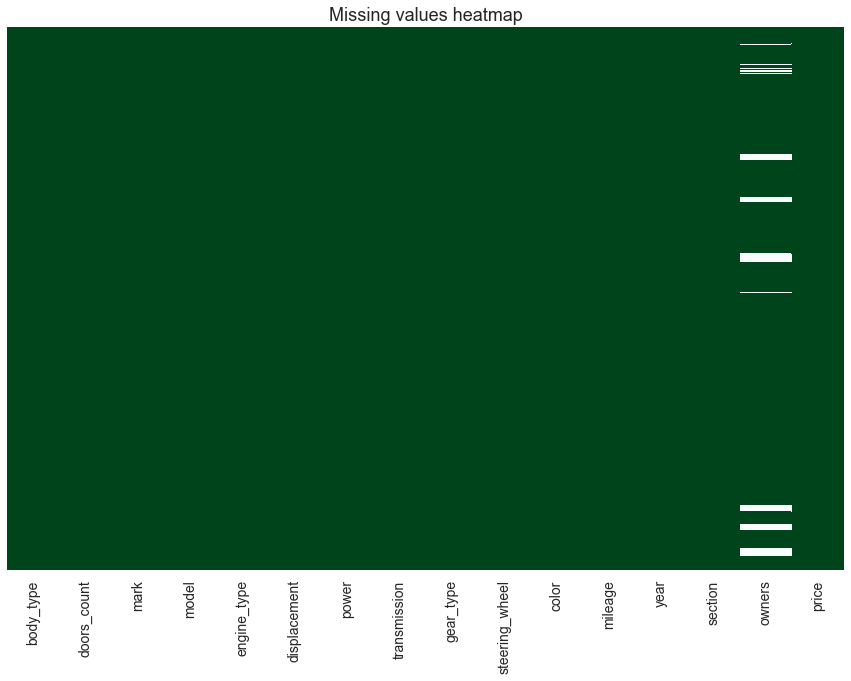

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
cmap = sns.diverging_palette(20, 275, s=80, as_cmap=True)

sns.heatmap(data.isna(), cmap='BuGn_r', cbar = False, yticklabels=False)

plt.xticks(fontsize=FONT_SIZE)
axes.set_title("Missing values heatmap", fontsize=FONT_SIZE+4)
axes.tick_params(axis='y', length=0)#, bottom=False)

In [18]:
print("Maximal amount of missing values ({}, i.e. {:.1%}) is in the '{}'.".format( data.isna().sum().max(), 
                                                                                  data.isna().sum().max()/len(data),
                                                                                  data.isna().sum().idxmax() ))

Maximal amount of missing values (11755, i.e. 9.5%) is in the 'owners'.


Пропуски есть только в признаке 'owners'.

In [19]:
data[ data['owners'].isna() ][['year', 'mileage', 'owners']]

year  mileage  owners
3280    2019        0     NaN
3282    2019        0     NaN
3283    2019        0     NaN
3286    2019        0     NaN
3287    2019        0     NaN
...      ...      ...     ...
122249  2018        0     NaN
122280  2018        0     NaN
122287  2018        0     NaN
122296  2018        0     NaN
122301  2018        0     NaN

[11755 rows x 3 columns]

In [20]:
data[ data['owners'].isna() ]['mileage'].value_counts()

0         11738
145000        1
295000        1
66000         1
83000         1
67000         1
200000        1
218000        1
120000        1
163000        1
110158        1
99164         1
74800         1
190000        1
110000        1
160000        1
95000         1
220000        1
Name: mileage, dtype: int64

Подавляющее число пропусков в 'owners' - это машины с нулевым пробегом, т.е., новые. Укажем таким машинам `owners=0`, остальные 13 пропусков удалим.

In [21]:
to_drop_mask = ( data['owners'].isna() ) & (data['mileage'] > 0)
print(to_drop_mask.sum())
to_drop_mask[ to_drop_mask==True ]

17


16976     True
21331     True
21580     True
23410     True
24733     True
33317     True
35760     True
42565     True
49694     True
50206     True
54752     True
56657     True
62441     True
74063     True
89149     True
95031     True
107023    True
dtype: bool

In [22]:
data = data.drop(index=to_drop_mask[ to_drop_mask==True ].index).reset_index(drop=True)
data = data.fillna(0)
data.isna().sum()

body_type         0
doors_count       0
mark              0
model             0
engine_type       0
displacement      0
power             0
transmission      0
gear_type         0
steering_wheel    0
color             0
mileage           0
year              0
section           0
owners            0
price             0
dtype: int64

## 3 Исследование признаков

Определим какие признаки являются:
- численными (numerical)
- категориальными (categorical) среди которых есть
  - упорядоченные (ordinal)
  - бинарные (binary)
  - прочие неупорядоченные

In [23]:
features_set = set(data.columns[:-1])

features_numerical = ['displacement', 'power', 'mileage', 'year']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = ['doors_count', 'owners']
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} variables.".format(len(features_set)))
print("There are {} numerical variables:".format( len(features_numerical) ), features_numerical)
print("There are {} categorical variables, amongst them:\n    {} ordinal variables:"
      .format( len(features_categorical_set), len(features_ordinal) ), features_ordinal)
print("        and")
print("    {} 'one-hot' variables:".
      format( len(features_one_hot) ), features_one_hot)

There are 15 variables.
There are 4 numerical variables: ['displacement', 'power', 'mileage', 'year']
There are 11 categorical variables, amongst them:
    2 ordinal variables: ['doors_count', 'owners']
        and
    9 'one-hot' variables: ['gear_type', 'mark', 'body_type', 'section', 'model', 'color', 'transmission', 'steering_wheel', 'engine_type']


### 3.2 Анализ численных переменных

In [24]:
def num_variable_analysis(df, item, target_name, n_bins=100):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (boxplot)    
    df.boxplot(column=item, ax=axes[0])
    axes[0].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 2 (distplot)
    sns.distplot(df[item], bins=n_bins, kde=True, ax=axes[1], vertical=True)
    axes[1].set_title(item, fontsize=FONT_SIZE)
    plt.xticks(rotation=45)
    # axes.set_xlim((0, 100))
    
    
    # === FIG 3 (scatterplot)
    if item != target_name:
        axes[2] = sns.scatterplot(x=item, y=target_name, data=df)
    
    
    # === Descriptive statistics
    describer = pd.DataFrame(df[item].describe()).T    
    print("==== {} ====".format(item))
    print(describer, "\n")
    
    
    # Pearson correlation coefficient for feature/target
    if item != target_name:
        corr_coeff = np.array(df[[item, target_name]].corr())[0, 1]
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}.".format( item, target_name, corr_coeff ), "\n")
    
    
    # === Missing values
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), "\n"*2)

#### 3.2.0 Целевой признак ('price')

In [25]:
data[target_name].min()

15000

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h4 style="color:red; margin-bottom:20px">
price or log_10(price)!</h4>

</div>

In [26]:
data['price_log10'] = np.log10(data[target_name])
target_name = 'price_log10'

==== price_log10 ====
                count      mean       std       min      25%       50%  \
price_log10  123324.0  5.771579  0.450932  4.176091  5.50515  5.763428   

                  75%       max  
price_log10  6.041393  7.929419   

There are 0 missing values in 'price_log10'. 




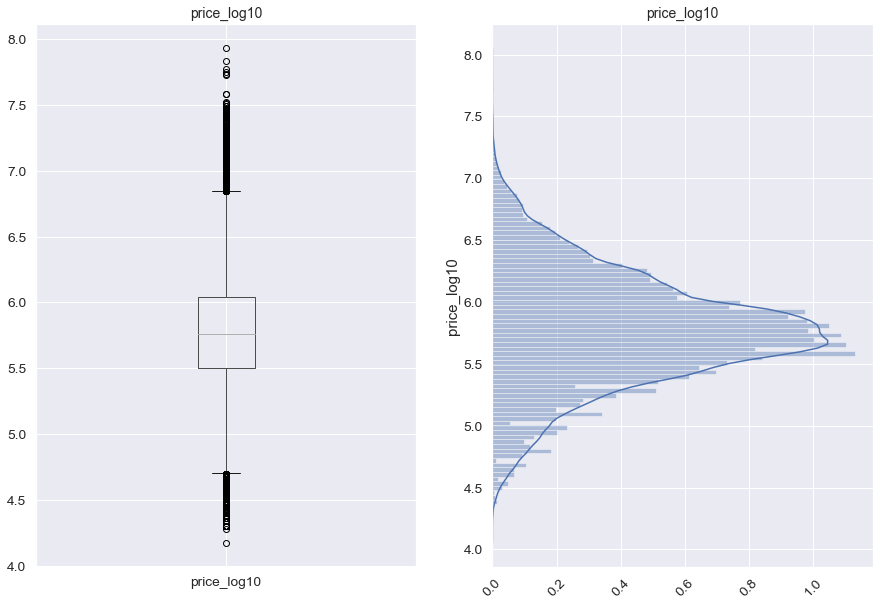

In [27]:
num_variable_analysis(data, target_name, target_name)

Рассмотрим отдельно несколько диапазонов цен:

1. "Низкие" цены (меьше 10 млн руб.)

==== price_log10 ====
                count      mean       std       min      25%       50%  \
price_log10  122798.0  5.765707  0.442771  4.176091  5.50515  5.759668   

                  75%       max  
price_log10  6.041393  6.999957   

There are 0 missing values in 'price_log10'. 




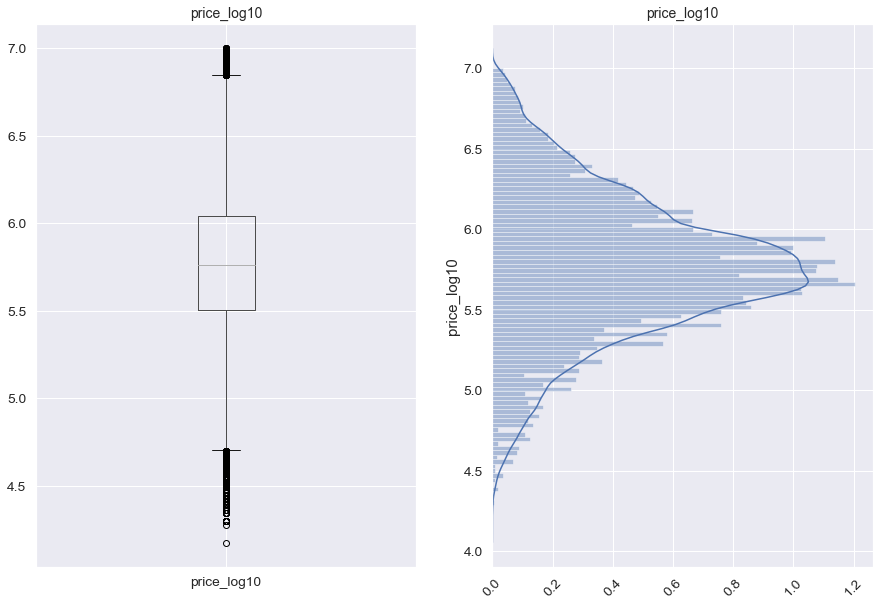

In [28]:
if target_name == 'price_log10':
    upper_price_limit = 7
else:
    upper_price_limit = 10*10**6

df = data[ data[target_name] < upper_price_limit ]

num_variable_analysis(df, target_name, target_name)

2. Высокие цены (выше 10 млн. руб.)

==== price_log10 ====
             count      mean       std       min       25%       50%  \
price_log10  520.0  7.144148  0.136748  7.000182  7.045842  7.103356   

                  75%       max  
price_log10  7.202116  7.929419   

There are 0 missing values in 'price_log10'. 




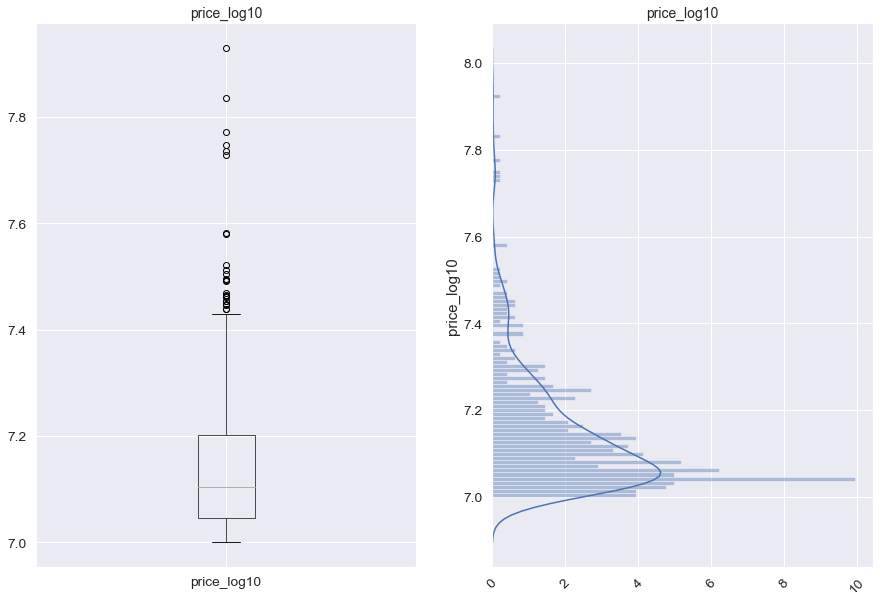

In [29]:
df = data[ data[target_name] > upper_price_limit ]

num_variable_analysis(df, target_name, target_name)

3. Промежуточный (с перекрытием) диапазон цен6 от 5 до 15 млн руб.

In [30]:
np.log10(1.5), np.log10(2)

(0.17609125905568124, 0.3010299956639812)

==== price_log10 ====
              count      mean      std      min       25%       50%       75%  \
price_log10  1672.0  6.956724  0.10986  6.82436  6.868995  6.926485  7.021189   

                  max  
price_log10  7.298853   

There are 0 missing values in 'price_log10'. 




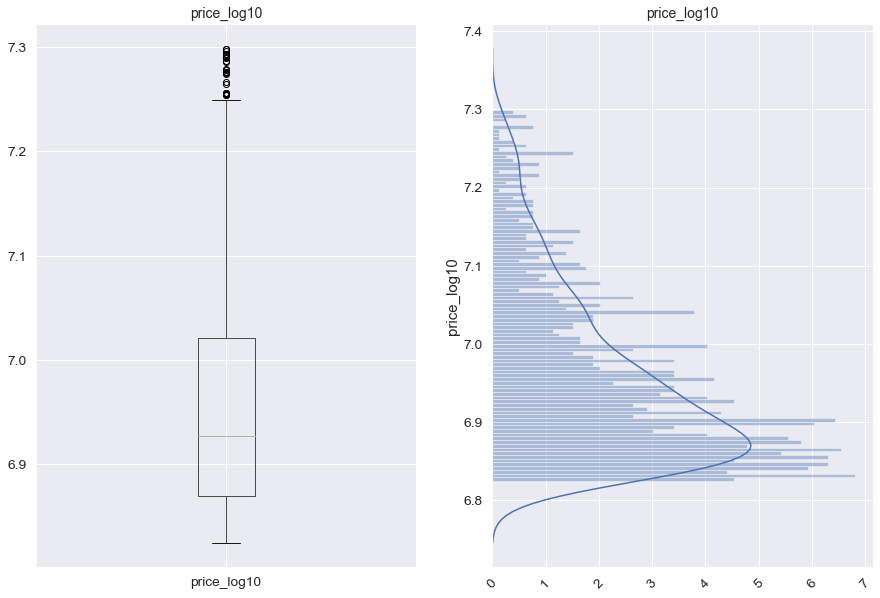

In [31]:
if target_name == 'price_log10':
    df = data[ (upper_price_limit-np.log10(1.5) < data[target_name]) & (data[target_name] < upper_price_limit+np.log10(2)) ]
else:
    df = data[ (0.5*upper_price_limit < data[target_name]) & (data[target_name] < 1.5*upper_price_limit) ]

num_variable_analysis(df, target_name, target_name)

На этоп этапе никаких аномалий не выявлено.

### 3.2.1 Численные признаки

==== displacement ====
                 count         mean         std  min     25%     50%     75%  \
displacement  123324.0  2152.667851  876.161122  0.0  1596.0  1975.0  2445.0   

                 max  
displacement  8285.0   

Pearson correlation coefficient between 'displacement' and 'price_log10' is 0.4434. 

There are 0 missing values in 'displacement'. 


==== power ====
          count        mean        std   min    25%    50%    75%    max
power  123324.0  163.011522  83.044485  11.0  109.0  143.0  190.0  950.0 

Pearson correlation coefficient between 'power' and 'price_log10' is 0.6343. 

There are 0 missing values in 'power'. 


==== mileage ====
            count           mean           std  min      25%       50%  \
mileage  123324.0  133320.438714  95188.471325  0.0  65000.0  125859.0   

              75%        max  
mileage  187005.5  1000000.0   

Pearson correlation coefficient between 'mileage' and 'price_log10' is -0.5192. 

There are 0 missing values in 'mile

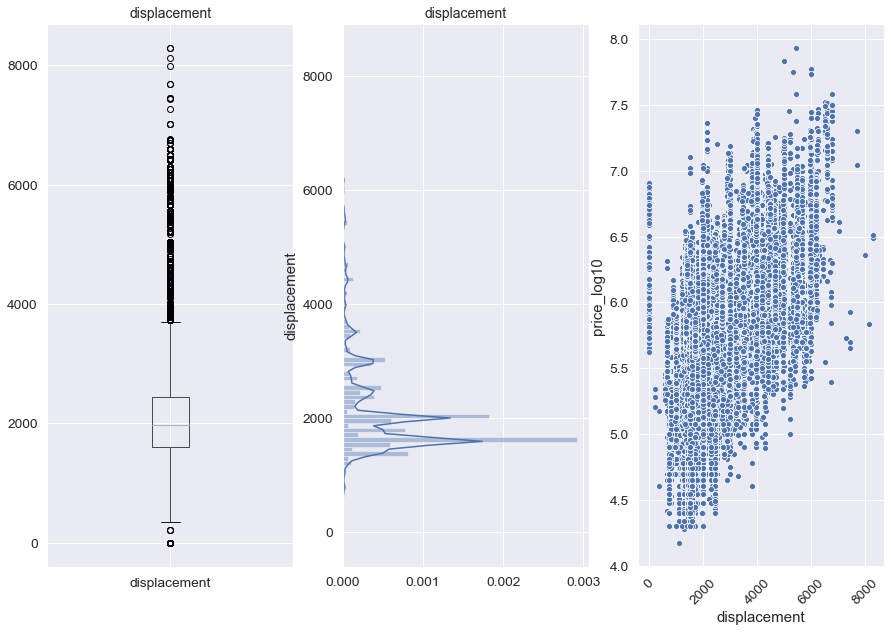

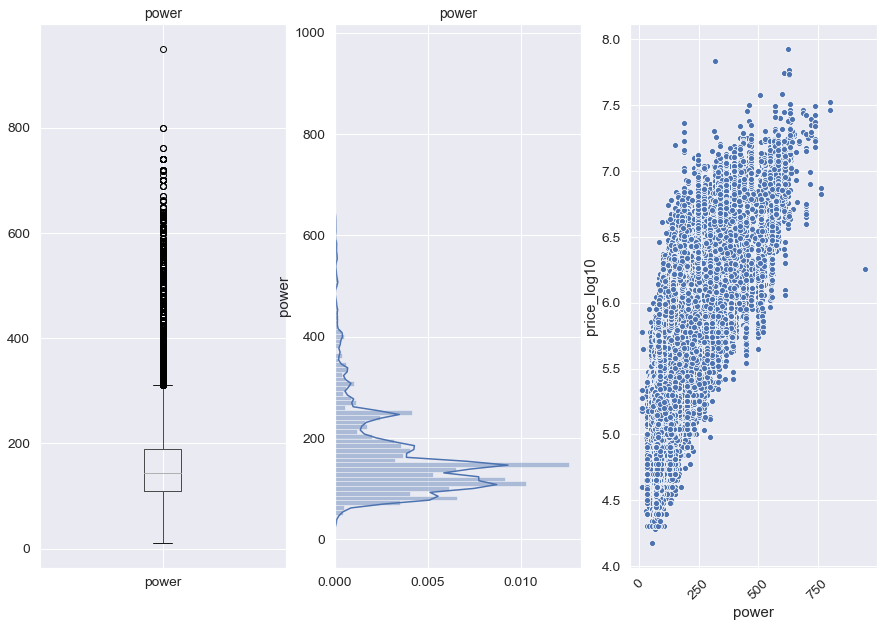

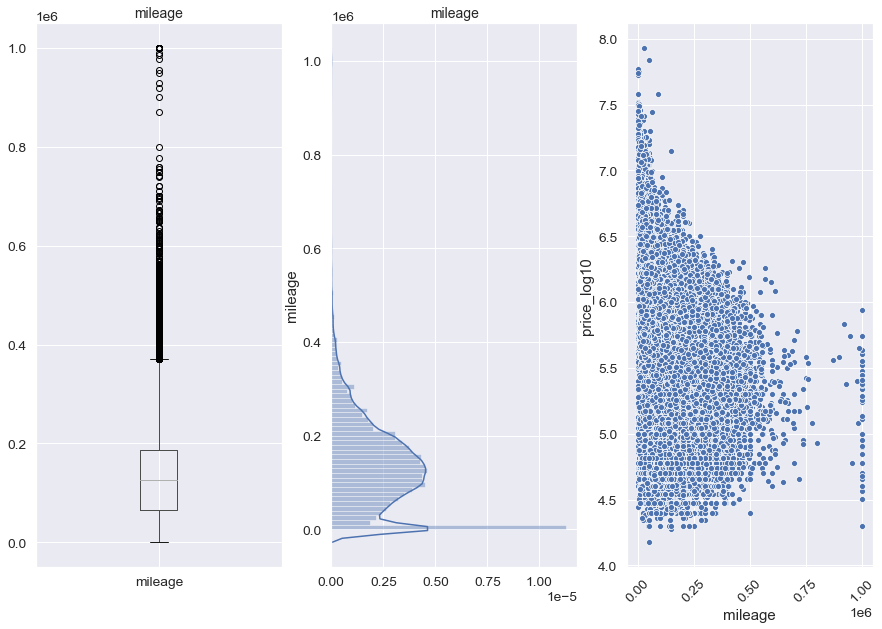

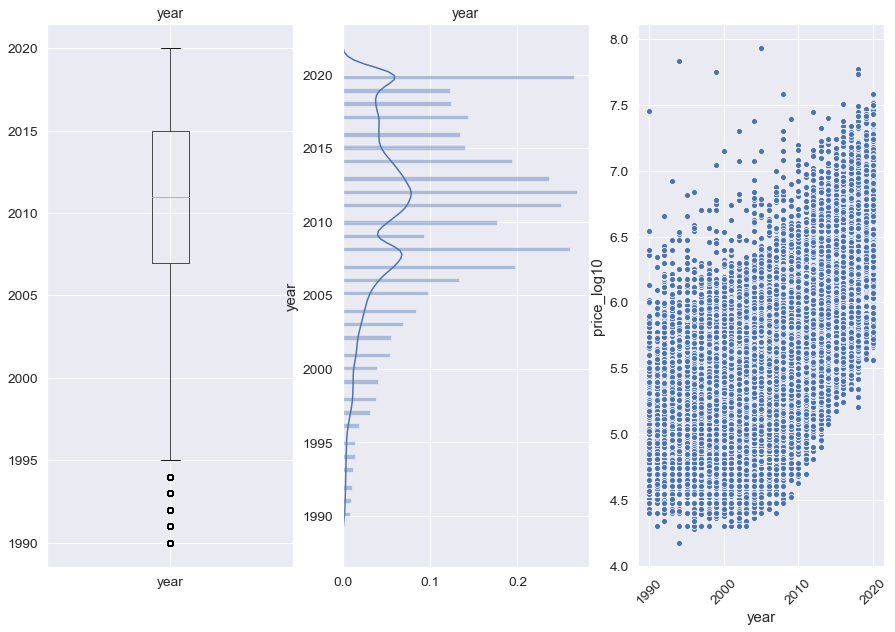

In [32]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

**Выделяются**:
1. 6 машин с ценой выше 40 млн руб.
2. несколько машин с объёмом двигателя свыше 7 л
3. автомобиль с мощностью двигателя 950 л.с.
4. минимальная мощность двигателя 11 л.с.
5. автомобили с нулевым объёмом двигателя
6. раритет 1990 года ценой за 2 млн руб

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h4 style="color:red; margin-bottom:20px">
Отсутствуют данные за 2006-2009 гг.!</h4>

</div>

In [33]:
if target_name != 'price_log10':
    limit = 40*10**6
else:
    limit = np.log10(40*10**6)
         
data[ data[target_name] > limit]

body_type  doors_count           mark            model engine_type  \
30511      SEDAN            4  Mercedes-Benz          S-Класс    GASOLINE   
53499      COUPE            2  Mercedes-Benz      SLR McLaren    GASOLINE   
86419      COUPE            2   Aston Martin       V8 Vantage    GASOLINE   
121263     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   
121267     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   
121273     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   

        displacement  power transmission   gear_type steering_wheel   color  \
30511           4973    320    AUTOMATIC  REAR_DRIVE           LEFT  0000CC   
53499           5439    626    AUTOMATIC  REAR_DRIVE           LEFT  040001   
86419           5341    608   MECHANICAL  REAR_DRIVE           LEFT  007F00   
121263          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  CACECB   
121267          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  040001   
121273          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  97948F   

        mileage  year section  owners     price  price_log10  
30511     49000  1994    used     2.0  68500000     7.835691  
53499     28000  2005    used     3.0  85000000     7.929419  
86419      4600  1999    used     2.0  56000000     7.748188  
121263        0  2018     new     0.0  53473436     7.728138  
121267        0  2018     new     0.0  59087576     7.771496  
121273        0  2018     new     0.0  54560408     7.736878

In [34]:
print(len(data[ data['displacement'] >= 7000 ]))
data[ data['displacement'] >= 7000 ]

13


body_type  doors_count       mark      model engine_type  \
251       ALLROAD            5  Chevrolet   Suburban    GASOLINE   
373       ALLROAD            5  Chevrolet   Suburban    GASOLINE   
18573   LIMOUSINE            4        ЗИЛ       4104    GASOLINE   
31820     ALLROAD            5  Chevrolet   Suburban    GASOLINE   
35493       COUPE            2  Chevrolet   Corvette    GASOLINE   
53757    ROADSTER            2      Dodge      Viper    GASOLINE   
53885      PICKUP            4  Chevrolet  Avalanche    GASOLINE   
86450   LIMOUSINE            4        ЗИЛ       4104    GASOLINE   
87796     MINIVAN            4       Ford  Econoline      DIESEL   
102100      COUPE            2  Chevrolet   Corvette    GASOLINE   
103051   ROADSTER            2      Dodge      Viper    GASOLINE   
104610      COUPE            2  Chevrolet   Corvette    GASOLINE   
116386      COUPE            2      Dodge      Viper    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  \
251             7446    290    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT   
373             7446    290    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT   
18573           7680    315    AUTOMATIC       REAR_DRIVE           LEFT   
31820           7443    233    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT   
35493           7011    513   MECHANICAL       REAR_DRIVE           LEFT   
53757           8285    507   MECHANICAL       REAR_DRIVE           LEFT   
53885           8128    325    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT   
86450           7680    315    AUTOMATIC       REAR_DRIVE           LEFT   
87796           7270    215    AUTOMATIC       REAR_DRIVE           LEFT   
102100          7011    513   MECHANICAL       REAR_DRIVE           LEFT   
103051          8285    507   MECHANICAL       REAR_DRIVE           LEFT   
104610          7011    513   MECHANICAL       REAR_DRIVE           LEFT   
116386          7990    456   MECHANICAL       REAR_DRIVE           LEFT   

         color  mileage  year section  owners     price  price_log10  
251     040001   136000  1996    used     3.0    850000     5.929419  
373     0000CC   401000  1996    used     3.0    500000     5.698970  
18573   040001     1000  2002    used     1.0  20000000     7.301030  
31820   FAFBFB   250000  1994    used     3.0    450000     5.653213  
35493   FFD600    39000  2007    used     3.0   3490000     6.542825  
53757   040001    22000  2005    used     3.0   3100000     6.491362  
53885   DEA522   270000  2005    used     3.0    680000     5.832509  
86450   040001     6700  1999    used     2.0  10999999     7.041393  
87796   040001   350000  1999    used     3.0    540000     5.732394  
102100  040001    35400  2006    used     1.0   3500000     6.544068  
103051  EE1D19    10300  2006    used     1.0   3250000     6.511883  
104610  FAFBFB    30000  2011    used     3.0   4100000     6.612784  
116386  EE1D19    28000  2001    used     1.0   2300000     6.361728

In [35]:
data[ data['power'] >= 900 ]

body_type  doors_count            mark                model  \
40540  SPEEDSTER            0  Гоночный болид  Шоу-кар «Формула-1»   

      engine_type  displacement  power transmission   gear_type  \
40540    GASOLINE          3000    950        ROBOT  REAR_DRIVE   

      steering_wheel   color  mileage  year section  owners    price  \
40540           LEFT  EE1D19        1  2004    used     1.0  1800000   

       price_log10  
40540     6.255273

In [36]:
data[ data['power']<30 ]

body_type  doors_count        mark     model engine_type  \
3       HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
1743    HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
7995        COUPE            2     Renault     Twizy     ELECTRO   
30611   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
31632   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
31687       COUPE            2         СМЗ      С-3Д    GASOLINE   
31967       COUPE            2         СМЗ      С-3Д    GASOLINE   
78714       COUPE            2     Renault     Twizy     ELECTRO   
88452   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
121261  HATCHBACK            4       Bajaj      Qute    GASOLINE   
121349  HATCHBACK            4       Bajaj      Qute    GASOLINE   
121493  HATCHBACK            4       Bajaj      Qute    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  \
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
1743             649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
7995               0     17    AUTOMATIC       REAR_DRIVE           LEFT   
30611            649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
31632            649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
31687            346     12   MECHANICAL       REAR_DRIVE           LEFT   
31967            346     12   MECHANICAL       REAR_DRIVE           LEFT   
78714              0     11    AUTOMATIC       REAR_DRIVE           LEFT   
88452            649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
121261           217     13        ROBOT       REAR_DRIVE           LEFT   
121349           217     13        ROBOT       REAR_DRIVE           LEFT   
121493           217     13        ROBOT       REAR_DRIVE           LEFT   

         color  mileage  year section  owners   price  price_log10  
3       EE1D19    50000  1998    used     1.0   26000     4.414973  
1743    22A0F8    16000  1996    used     1.0   95000     4.977724  
7995    FAFBFB     1959  2012    used     2.0  449000     5.652246  
30611   FAFBFB    76000  1993    used     3.0   50000     4.698970  
31632   0000CC    30000  1990    used     3.0  195000     5.290035  
31687   22A0F8     2400  1994    used     1.0   40000     4.602060  
31967   22A0F8       16  1994    used     1.0  150000     5.176091  
78714   040001     1500  2016    used     2.0  599000     5.777427  
88452   EE1D19    68000  2000    used     3.0   45000     4.653213  
121261  FAFBFB     2000  2018    used     1.0  190000     5.278754  
121349  FAFBFB     3629  2018    used     1.0  160000     5.204120  
121493  040001       13  2018    used     1.0  219000     5.340444

In [37]:
limit_t = 20*10**6
if target_name == 'price_log10':
    limit_t = np.log10(20*10**6)
    
    
data[ (data['year']==1990) & (data[target_name] > limit_t)]

body_type  doors_count         mark  model engine_type  displacement  \
30520    PICKUP            4  Lamborghini  LM002    GASOLINE          5167   

       power transmission        gear_type steering_wheel   color  mileage  \
30520    455   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  040001    10000   

       year section  owners     price  price_log10  
30520  1990    used     3.0  28500000     7.454845

In [38]:
print(len(data[ data['displacement']==0 ]))
data[ data['displacement']==0 ]['engine_type']

91


3295      ELECTRO
5564      ELECTRO
5602      ELECTRO
5613      ELECTRO
5738      ELECTRO
           ...   
100884    ELECTRO
114504    ELECTRO
114805    ELECTRO
122011    ELECTRO
122016    ELECTRO
Name: engine_type, Length: 91, dtype: object

In [39]:
data[ data['displacement']==0 ]['engine_type'].value_counts()

ELECTRO    91
Name: engine_type, dtype: int64

1. 6 машин с ценой выше 40 млн руб.- несколько машин с объёмом двигателя свыше 7 л
 - люксовые (Maybach S-Класс и Mercedes-Benz S-Класс (W220)) и спортивные машины (Mercedes-Benz SLR McLaren, Aston Martin Vantage). С Aston Martin Vantage есть загадка: модель выпускалась с 2005, а в базе стоит 1999 год...
2. 13 машин с объёмом двигателя свыше 7 л
 - 3 "пассажирских грузовика" (SUV) Chevrolet Suburban 9-го поколения и его производная Chevrolet Avalanche
 - 2 "членовоза" ЗИЛ-41047
 - "спортсмены" Dodge Viper и Chevrolet Corvette (по 3 штуки)
 - фургон Ford Econoline
3. автомобиль с мощностью двигателя 950 л.с.
 - Шоу-кар «Формула-1»
4. аавтомобили с мощностью двигателя меньше 30 л.с.:
 - СМЗ С-3Д - инвалидка" (2)
 - Bajaj Qute - индийский квадрицикл (3)
 - Renault Twizy - еропейский электро-квадрицикл (2)
 - LADA (ВАЗ) - 1111 Ока (5) 
5. автомобили с нулевым объёмом двигателя
 - электромобили
6. раритет 1990 года ценой за 2 млн
 - Это внедорожник Lamborghini LM002 ! 
 
Далеко не рядовые 109 машин. Все они имеют право на существование, но для общего рынка будут скорее аномалиями и способны подпортить предсказатель.

Сейчас удаляем все, кроме "Оки". Будет время - попробуем вернуть частями и посмотреть как изменится модель. В первую очередь - "электрички".

In [40]:
if target_name == 'price_log10':
    data = data[ data[target_name] < np.log10(40*10**6)]
else:
    data = data[ data[target_name] < 40*10**6]

data = data[ data['displacement'] <= 7000 ]
data = data[ data['power'] < 900 ]
data = data[ data['power'] > 20 ]
data = data[ data['engine_type'] != 'ELECTRO' ]

if target_name == 'price_log10':
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > np.log10(20*10**6))].index
else:
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > 20*10**6)].index
    
data = data.drop(index=index_to_drop).reset_index(drop=True)
data

body_type  doors_count        mark       model engine_type  \
0       COMPACTVAN            4      Nissan      Serena      DIESEL   
1          ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2        HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3        HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4        HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...            ...          ...         ...         ...         ...   
123202     ALLROAD            5         УАЗ     Patriot    GASOLINE   
123203     ALLROAD            5   Chevrolet        Niva    GASOLINE   
123204     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
123205     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
123206     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  \
0               1973     91    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT   
1               1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
2               1598     75    AUTOMATIC  FORWARD_CONTROL           LEFT   
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
4               2324    150   MECHANICAL  FORWARD_CONTROL           LEFT   
...              ...    ...          ...              ...            ...   
123202          2693    135   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
123203          1690     80   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
123204          1998    146     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
123205          2360    167     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
123206          1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   

         color  mileage  year section  owners    price  price_log10  
0       FAFBFB   200000  1996    used     2.0   195000     5.290035  
1       FAFBFB    36000  1998    used     2.0   295000     5.469822  
2       007F00   224000  1997    used     3.0   169000     5.227887  
3       EE1D19    50000  1998    used     1.0    26000     4.414973  
4       CACECB   200000  1998    used     3.0   145000     5.161368  
...        ...      ...   ...     ...     ...      ...          ...  
123202  CACECB    15000  2018    used     1.0   850000     5.929419  
123203  007F00    29000  2018    used     1.0   569000     5.755112  
123204  97948F    38000  2018    used     1.0  1650000     6.217484  
123205  FAFBFB    56800  2018    used     1.0  1850000     6.267172  
123206  040001    21000  2018    used     3.0   510000     5.707570  

[123207 rows x 17 columns]

После "первичной очистки" снова глянем на численные признаки:

==== displacement ====
                 count         mean         std    min     25%     50%  \
displacement  123207.0  2153.560439  872.356933  599.0  1596.0  1975.0   

                 75%     max  
displacement  2445.0  6761.0   

Pearson correlation coefficient between 'displacement' and 'price_log10' is 0.4457. 

There are 0 missing values in 'displacement'. 


==== power ====
          count        mean        std   min    25%    50%    75%    max
power  123207.0  162.922399  82.760078  29.0  109.0  143.0  190.0  800.0 

Pearson correlation coefficient between 'power' and 'price_log10' is 0.6341. 

There are 0 missing values in 'power'. 


==== mileage ====
            count           mean           std  min      25%       50%  \
mileage  123207.0  133394.512024  95166.248148  0.0  65453.5  126000.0   

              75%        max  
mileage  187282.5  1000000.0   

Pearson correlation coefficient between 'mileage' and 'price_log10' is -0.5192. 

There are 0 missing values in '

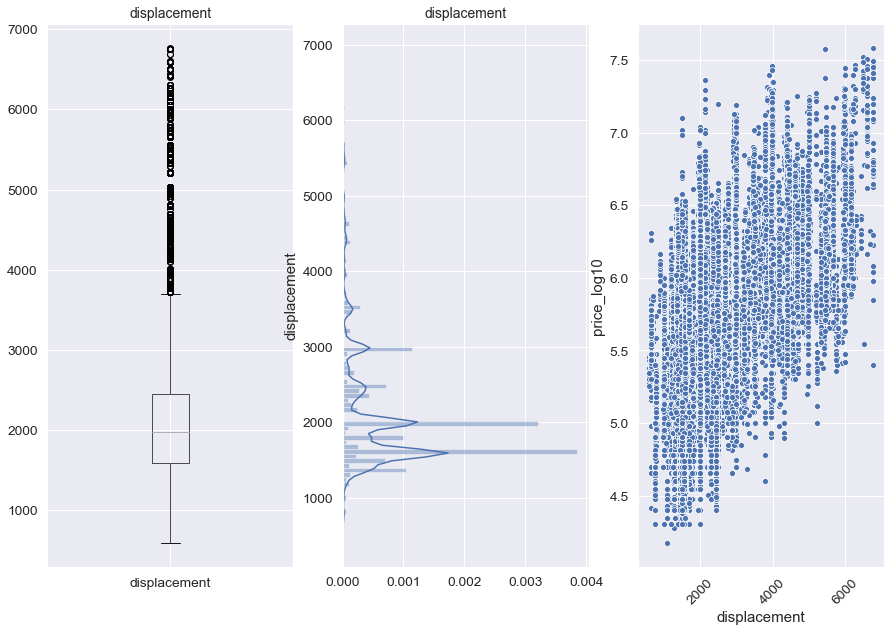

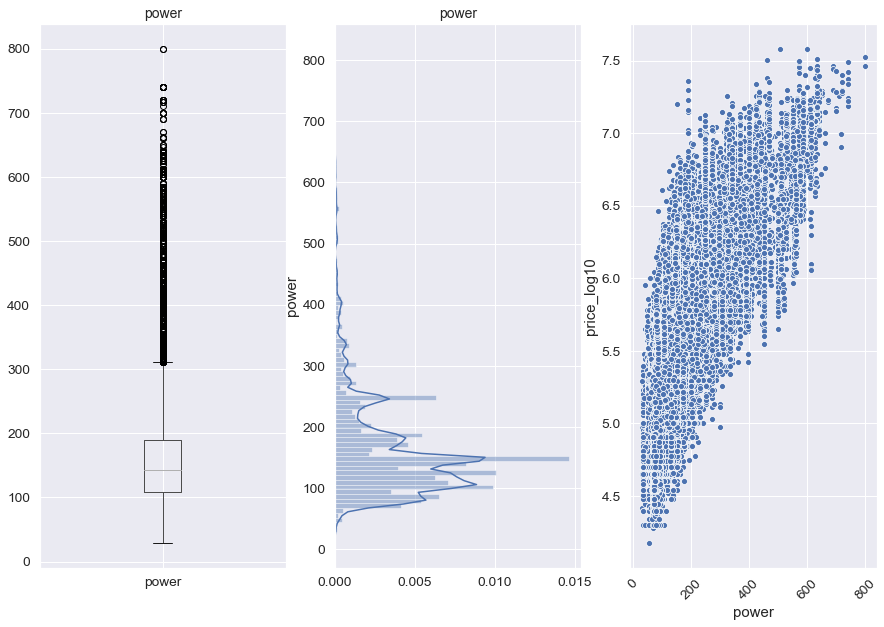

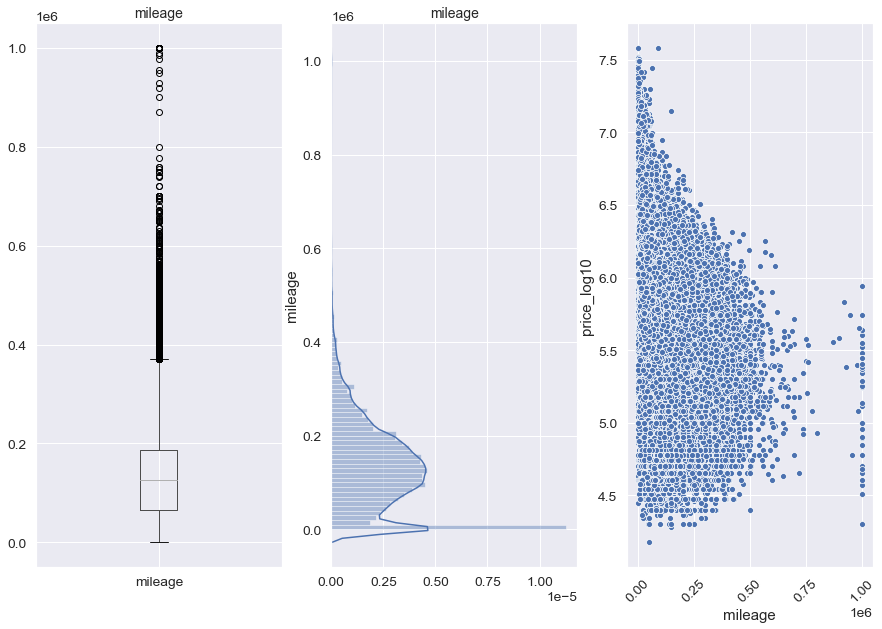

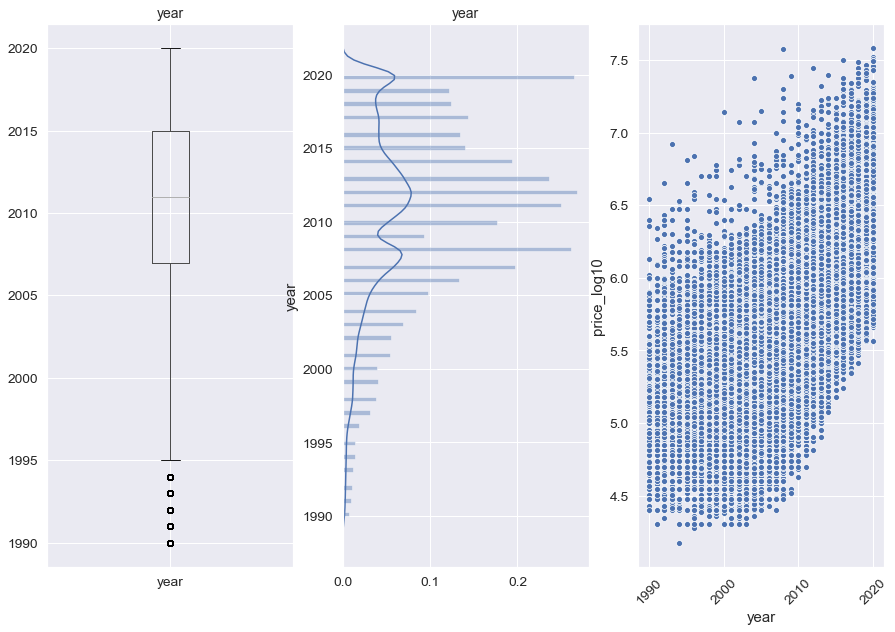

In [41]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

Вопиющих аномалий не видно.

### 3.2.2 Категориальные признаки (вообще)

Сколько в каждом категориальном признаке категорий:

In [42]:
categorical_unique_dict = dict()
for item in features_categorical:
    categorical_unique_dict[item] = data[item].nunique()

categorical_unique = pd.Series(categorical_unique_dict, index=categorical_unique_dict.keys()).sort_values(ascending=False)
categorical_unique

model             1393
mark               120
color               16
body_type           16
doors_count          5
transmission         4
owners               4
engine_type          4
gear_type            3
steering_wheel       2
section              2
dtype: int64

In [43]:
print("We have {} binary variables.".format(categorical_unique[ categorical_unique == 2 ].count()))

We have 2 binary variables.


В признаках `model` и `mark` очень много категорий.
**Нет ли дублирований ?**



### 3.2.3 Упорядоченные категориальные признаки (Ordinal features)

In [44]:
def ordinal_variable_analysis(df, item, target_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count()
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0], palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=45)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    
    # ==== FIG 2 (boxplots for classes)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])    
    bx_plot.set_xticklabels(bar_data.index, rotation=45)
    plt.xticks(rotation=45)
    axes[1].set_title(item, fontsize=FONT_SIZE)

        
    # ==== FIG 3 (kdeplots for classes)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.kdeplot(df[ df[item] == value ][target_name], vertical=True, ax=axes[2], label=value)    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    
    # === Descriptive statistics
    
    print("==== {} ====\n".format(item))
    if item != target_name:
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}."
              .format( item, 
                      target_name, 
                      np.array(df[[item, target_name]].corr())[0, 1] ), "\n")
    
    print(bar_data, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)

==== doors_count ====

Pearson correlation coefficient between 'doors_count' and 'price_log10' is 0.1377. 

doors_count
0        2
2     2463
3     4144
4    46474
5    70124
Name: doors_count, dtype: int64 

There are 0 missing values in 'doors_count'. 


==== owners ====

Pearson correlation coefficient between 'owners' and 'price_log10' is -0.5375. 

owners
0.0    11730
1.0    29914
2.0    31814
3.0    49749
Name: owners, dtype: int64 

There are 0 missing values in 'owners'. 




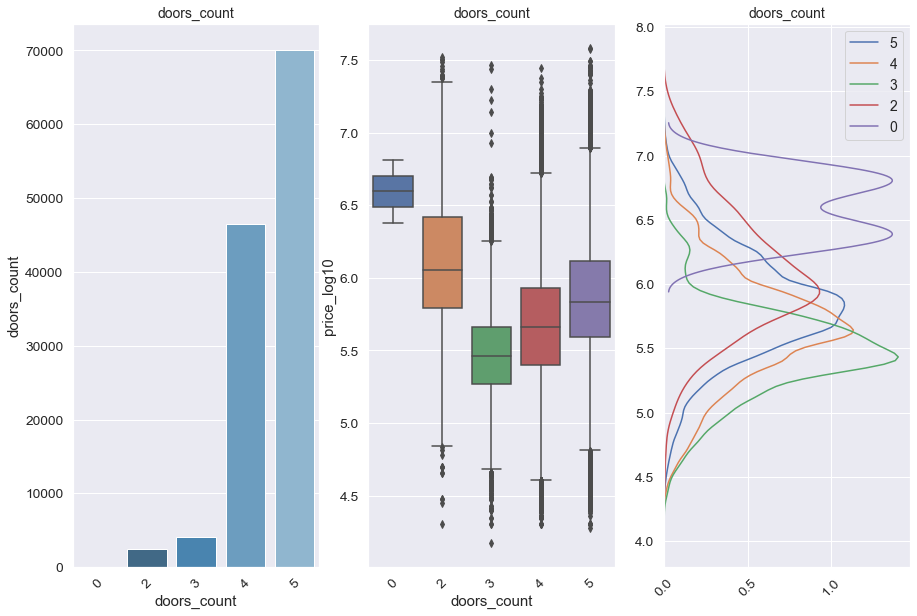

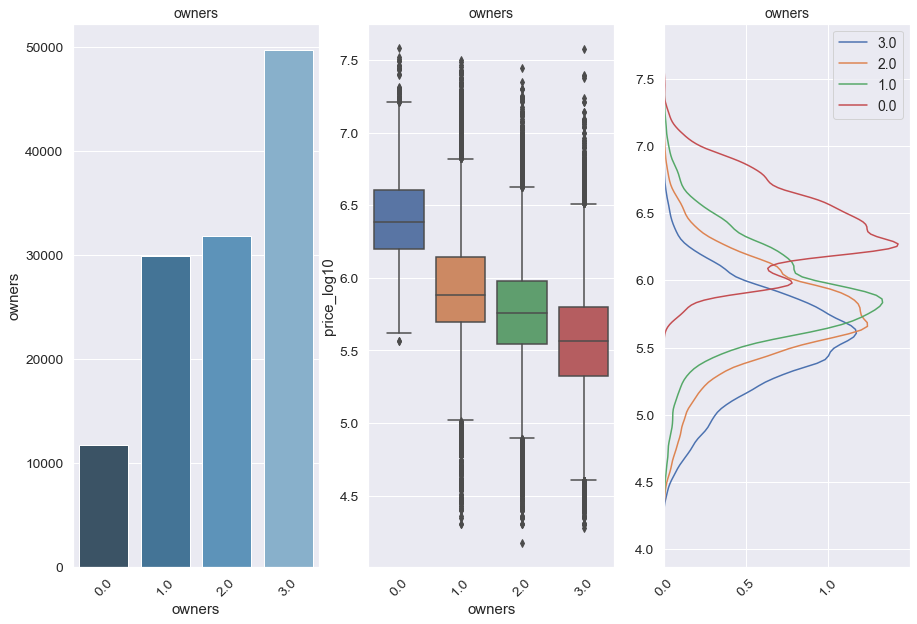

In [45]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

Из аномалий - 0-дверная машина (2 штуки) и пятидверки с ценой свыше 35 млн руб.

In [46]:
data[ data['doors_count']==0 ]

body_type  doors_count            mark             model engine_type  \
35523   ROADSTER            0           Ariel              Atom    GASOLINE   
86367  SPEEDSTER            0  Гоночный болид  Dallara F399/300    GASOLINE   

       displacement  power transmission   gear_type steering_wheel   color  \
35523          1998    300   MECHANICAL  REAR_DRIVE           LEFT  040001   
86367          2000    215   MECHANICAL  REAR_DRIVE           LEFT  0000CC   

       mileage  year section  owners    price  price_log10  
35523     2000  2007    used     1.0  6500000     6.812913  
86367    37000  1999    used     1.0  2408067     6.381669

In [47]:
limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

print(limit_t)
data[ (data['doors_count']==5) & (data[target_name]>limit_t) ]

7.544068044350276


body_type  doors_count           mark        model engine_type  \
72494    ALLROAD            5  Mercedes-Benz  G-Класс AMG    GASOLINE   
119121   ALLROAD            5    Rolls-Royce     Cullinan    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  \
72494           5439    507    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT   
119121          6749    600    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT   

         color  mileage  year section  owners     price  price_log10  
72494   97948F    89000  2008    used     3.0  38000000     7.579784  
119121  040001        0  2020     new     0.0  38200000     7.582063

Машинами без дверей оказались гоночные болиды Dallara F399/300 и Ariel Atom. Удаляем как редкую редкость.

Машинами с ценой за 35 млн руб. оказался люксовый внедорожник Rolls-Royce Cullinan и Geländewagen. Тоже удаляем как редких птиц для российского (даже московского) авторынка.

In [48]:
data = data[ data['doors_count']>0 ]

limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

data = data[ data[target_name]<limit_t ].reset_index(drop=True)

После "первичной очистки" снова глянем на упорядоченные категориальные признаки:

==== doors_count ====

Pearson correlation coefficient between 'doors_count' and 'price_log10' is 0.1379. 

doors_count
2     2463
3     4144
4    46474
5    70122
Name: doors_count, dtype: int64 

There are 0 missing values in 'doors_count'. 


==== owners ====

Pearson correlation coefficient between 'owners' and 'price_log10' is -0.5375. 

owners
0.0    11729
1.0    29912
2.0    31814
3.0    49748
Name: owners, dtype: int64 

There are 0 missing values in 'owners'. 




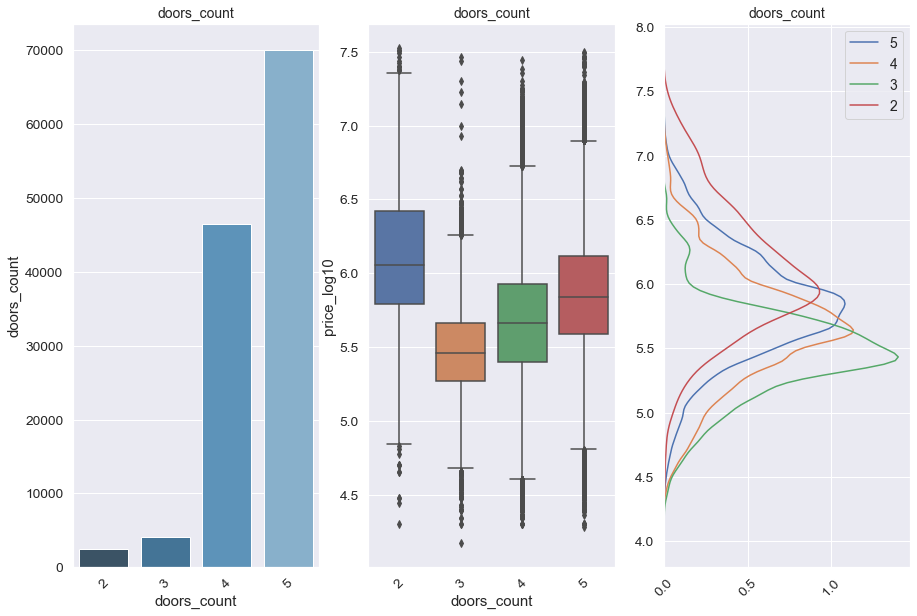

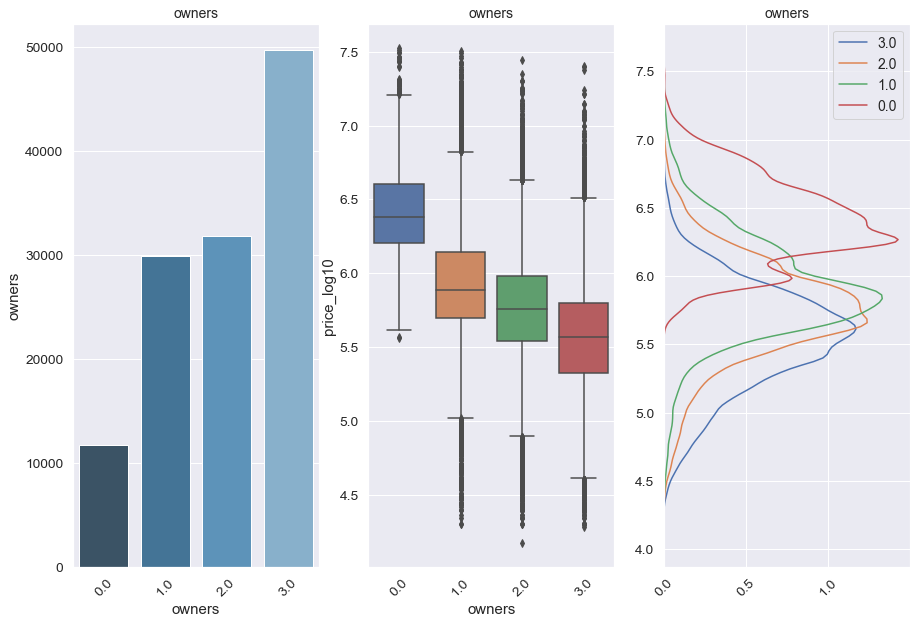

In [49]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

Вопиющих аномалий не видно.

### 3.2.3 Категориальные 'One-hot' признаки

In [50]:
features_one_hot

['gear_type',
 'mark',
 'body_type',
 'section',
 'model',
 'color',
 'transmission',
 'steering_wheel',
 'engine_type']

Вновь выведем количество уникальных значений для 'one-hot' переменных.

In [51]:
one_hot_unique = data[features_one_hot].nunique().sort_values(ascending=False)
one_hot_unique

model             1391
mark               118
color               16
body_type           16
engine_type          4
transmission         4
gear_type            3
steering_wheel       2
section              2
dtype: int64

Поскольку у двух признаков `model` и `mark` очень много категорий (1317 и 108, соответственно), их подвергать "классическому анализу" не будем, но вот проверить на наличие "близнецов" стоит.

In [52]:
features_one_hot_short = list(set(features_one_hot) - set(['model', 'mark']))
features_one_hot_short

['gear_type',
 'body_type',
 'section',
 'color',
 'transmission',
 'steering_wheel',
 'engine_type']

In [53]:
data['color'].value_counts(ascending=False)

040001    32468
FAFBFB    21770
CACECB    16150
97948F    14700
0000CC    11838
EE1D19     6499
200204     5499
007F00     4616
C49648     2757
22A0F8     1938
660099     1188
DEA522     1053
4A2197      983
FFD600      950
FF8649      756
FFC0CB       38
Name: color, dtype: int64

Преобразуем 16-ричную кодировку цвета в названия.

In [54]:
## https://hysy.org/color/97948F
## https://www.colorhexa.com/0000cc

color_dict = {}

color_dict['040001'] = 'black'  ## в ПТС как чёрный (#601)
color_dict['FAFBFB'] = 'white'
color_dict['CACECB'] = 'light-grey'
color_dict['97948F'] = 'grey'
color_dict['0000CC'] = 'strong-blue'

color_dict['200204'] = 'mostly-black-red'  ## в ПТС как коричневый металлик (#798)
color_dict['EE1D19'] = 'Vivid red'
color_dict['007F00'] = 'dark-green'
color_dict['C49648'] = 'french-beige'
color_dict['22A0F8'] = 'vivid-blue'  ## лазурный

color_dict['FFD600'] = 'yellow'
color_dict['660099'] = 'dark-violet'
color_dict['4A2197'] = 'dark-blue'
color_dict['DEA522'] = 'golden'
color_dict['FF8649'] = 'peach'
color_dict['FFC0CB'] = 'pink'

data['color'] = data['color'].map(color_dict)
data

body_type  doors_count        mark       model engine_type  \
0       COMPACTVAN            4      Nissan      Serena      DIESEL   
1          ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2        HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3        HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4        HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...            ...          ...         ...         ...         ...   
123198     ALLROAD            5         УАЗ     Patriot    GASOLINE   
123199     ALLROAD            5   Chevrolet        Niva    GASOLINE   
123200     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
123201     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
123202     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  \
0               1973     91    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT   
1               1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
2               1598     75    AUTOMATIC  FORWARD_CONTROL           LEFT   
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT   
4               2324    150   MECHANICAL  FORWARD_CONTROL           LEFT   
...              ...    ...          ...              ...            ...   
123198          2693    135   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
123199          1690     80   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
123200          1998    146     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
123201          2360    167     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
123202          1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   

             color  mileage  year section  owners    price  price_log10  
0            white   200000  1996    used     2.0   195000     5.290035  
1            white    36000  1998    used     2.0   295000     5.469822  
2       dark-green   224000  1997    used     3.0   169000     5.227887  
3        Vivid red    50000  1998    used     1.0    26000     4.414973  
4       light-grey   200000  1998    used     3.0   145000     5.161368  
...            ...      ...   ...     ...     ...      ...          ...  
123198  light-grey    15000  2018    used     1.0   850000     5.929419  
123199  dark-green    29000  2018    used     1.0   569000     5.755112  
123200        grey    38000  2018    used     1.0  1650000     6.217484  
123201       white    56800  2018    used     1.0  1850000     6.267172  
123202       black    21000  2018    used     3.0   510000     5.707570  

[123203 rows x 17 columns]

In [55]:
def rounder(x, m=2):
    return round(x, m)

def one_hot_variable_analysis(df, item, target_name, n_bins=100, class_balance_threshold=3):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count().sort_values(ascending=False)
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0])#, palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=90)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    # ==== FIG 2 (boxplot)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])
    bx_plot.set_xticklabels(bar_data.index, rotation=90)
    axes[1].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 3 (distplot)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.distplot(df[ df[item] == value ][target_name], bins=n_bins, kde=True, norm_hist=True, 
                     vertical=True, ax=axes[2], label=value)
    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    
    # === Descriptive statistics    
    
    print("==== {} ====\n".format(item))
    
    
    print(bar_data, "\n")
    
    
    values = df[item].value_counts()
    k = 0
    for value in values.index:
        describer_value = pd.DataFrame(df[ df[item] == value ][target_name].describe())
#         ! print("!!!\n", values, "\n")
        if k == 0:
            describer = describer_value.copy()
        else:
            describer = pd.concat([describer, describer_value], axis=1)
        k += 1    
    describer.columns = values.index
    describer = describer.T
    describer_moments = pd.DataFrame([describer.mean(), describer.std()], index=['MEAN', 'STD'])
    describer = pd.concat([describer, describer_moments], axis=0)
    describer = describer.apply(rounder)
    print(describer, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)
    
    if class_balance_threshold > 0:
        print("Class balance ratio (to previous):")
        bar_data_sorted = bar_data.sort_values()
        class_balance_ratio = round(np.exp(np.log(bar_data_sorted).diff()), 2)
        print(class_balance_ratio, "\n")    
        if class_balance_ratio.max() > class_balance_threshold:
            print("It seems to be a severe CLASS IMBALANCE: Maximal Class balance ratio (to previous) is", 
                  class_balance_ratio.max(), "\n")
        else:
            print("Maximal Class balance ratio (to previous) is ", class_balance_ratio.max(), "\n")
        return class_balance_ratio.max()

==== gear_type ====

gear_type
FORWARD_CONTROL    68261
ALL_WHEEL_DRIVE    44685
REAR_DRIVE         10257
Name: gear_type, dtype: int64 

                    count  mean   std   min   25%   50%   75%   max
FORWARD_CONTROL  68261.00  5.59  0.36  4.18  5.40  5.62  5.82  6.90
ALL_WHEEL_DRIVE  44685.00  6.06  0.41  4.51  5.79  6.03  6.33  7.50
REAR_DRIVE       10257.00  5.70  0.55  4.30  5.39  5.80  6.06  7.52
MEAN             41067.67  5.78  0.44  4.33  5.52  5.82  6.07  7.31
STD              29170.70  0.24  0.10  0.17  0.23  0.20  0.26  0.35 

There are 0 missing values in 'gear_type'. 


Class balance ratio (to previous):
gear_type
REAR_DRIVE          NaN
ALL_WHEEL_DRIVE    4.36
FORWARD_CONTROL    1.53
Name: gear_type, dtype: float64 

It seems to be a severe CLASS IMBALANCE: Maximal Class balance ratio (to previous) is 4.36 



C:\Users\DNS\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


==== body_type ====

body_type
SEDAN         44387
ALLROAD       42342
HATCHBACK     16982
WAGON          5913
LIFTBACK       4800
COMPACTVAN     2634
MINIVAN        2616
COUPE          1958
PICKUP          834
VAN             268
ROADSTER        209
CABRIO          201
MICROVAN         47
TARGA             8
LIMOUSINE         3
SPEEDSTER         1
Name: body_type, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
SEDAN       44387.00  5.65  0.44  4.30  5.39  5.65  5.90  7.45
ALLROAD     42342.00  6.02  0.37  4.60  5.78  5.98  6.26  7.50
HATCHBACK   16982.00  5.49  0.36  4.18  5.30  5.53  5.70  7.47
WAGON        5913.00  5.55  0.37  4.40  5.32  5.59  5.79  7.16
LIFTBACK     4800.00  5.79  0.36  4.48  5.62  5.79  6.00  7.24
COMPACTVAN   2634.00  5.58  0.27  4.65  5.40  5.56  5.72  6.38
MINIVAN      2616.00  5.92  0.41  4.60  5.61  5.92  6.20  7.36
COUPE        1958.00  6.12  0.50  4.70  5.79  6.05  6.45  7.52
PICKUP        834.00  6.01  0.36  5.00  5.74  5.99

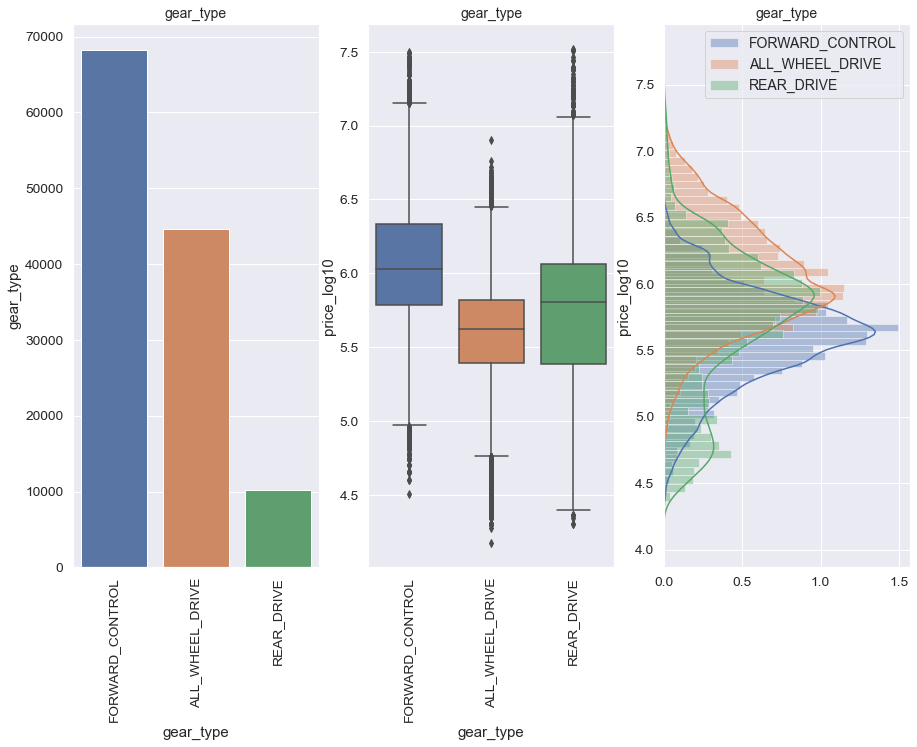

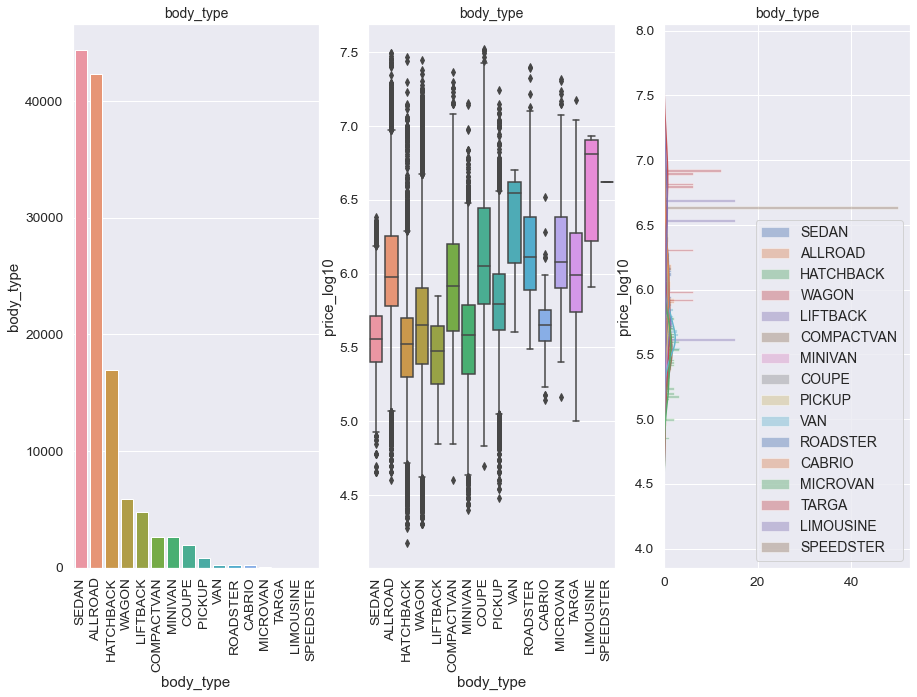

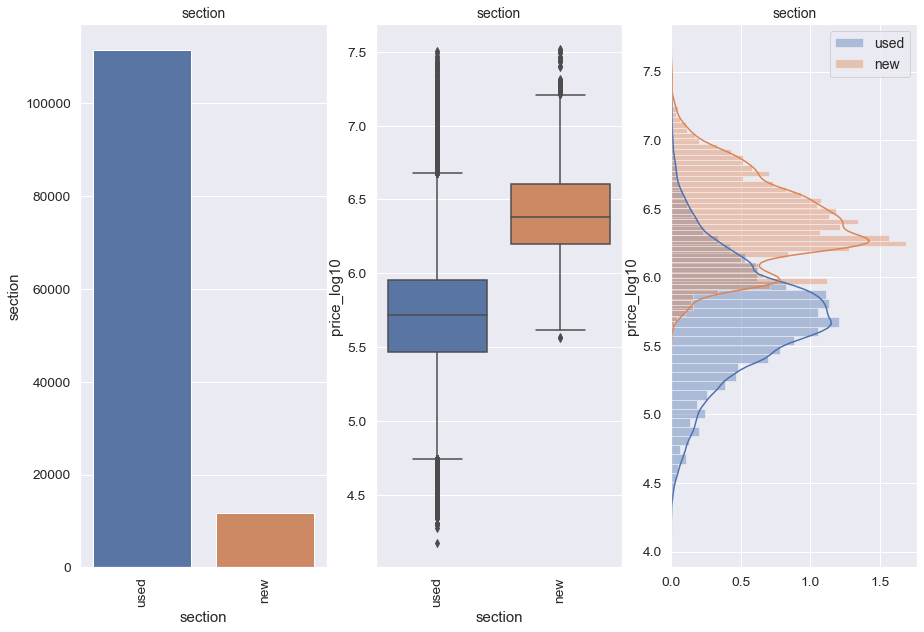

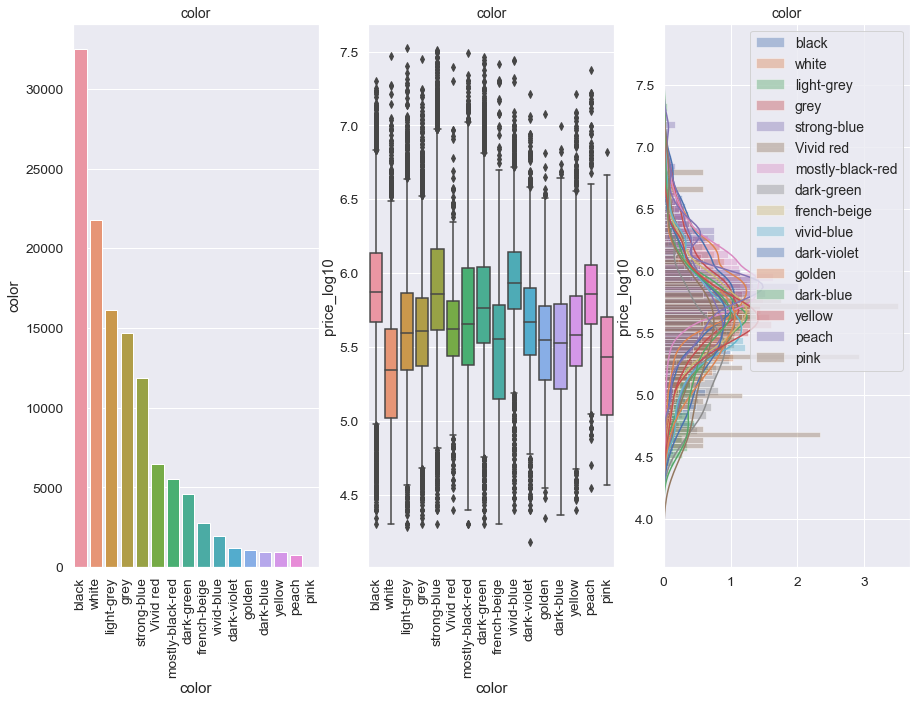

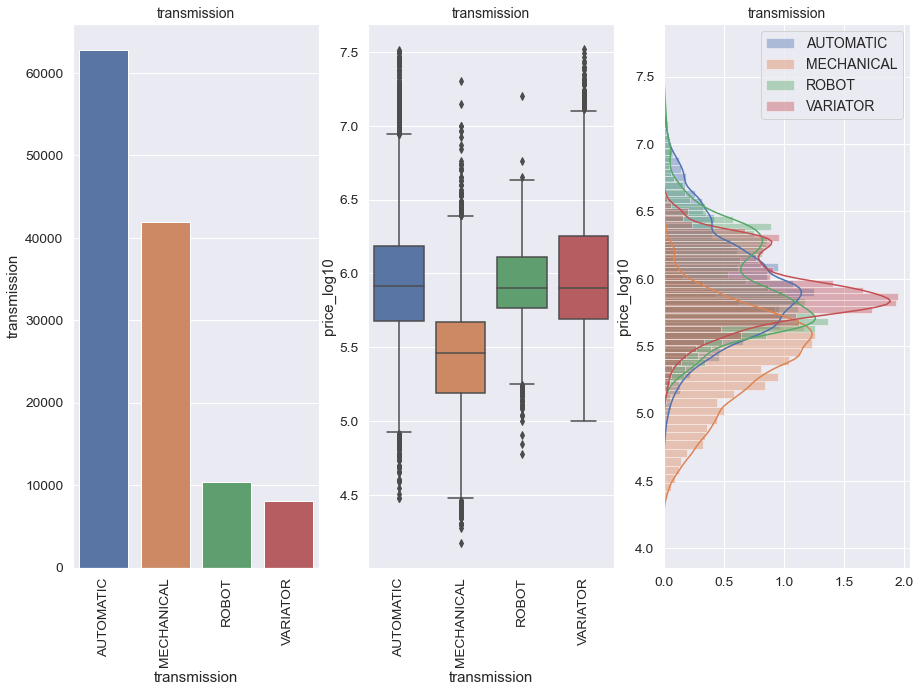

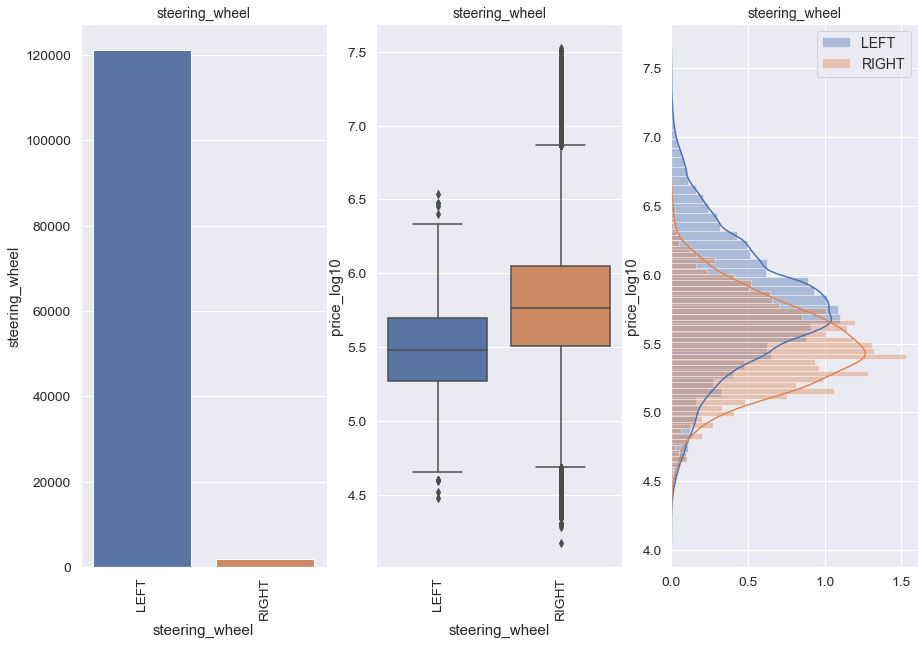

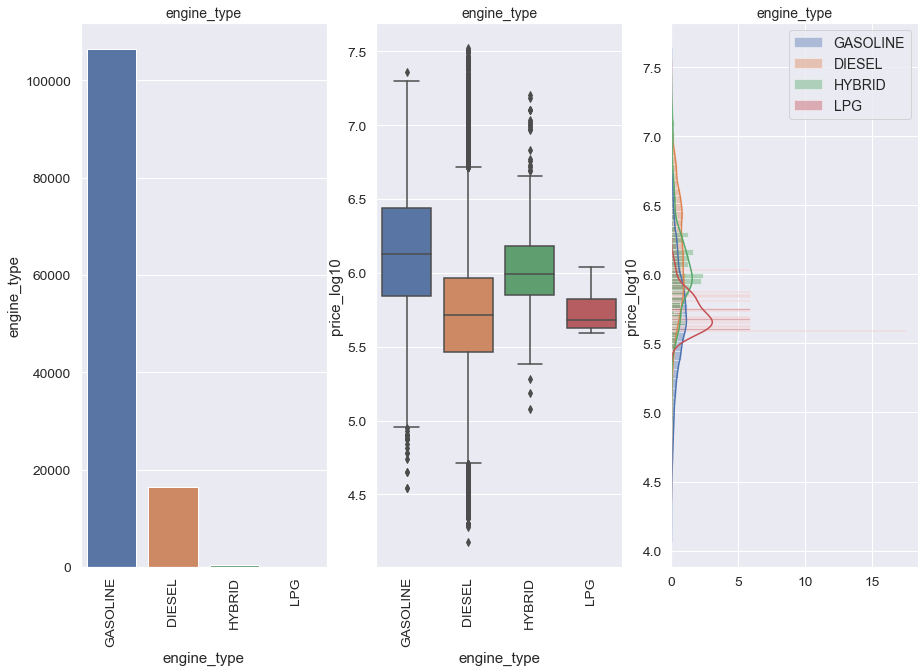

In [56]:
for item in features_one_hot_short:
    one_hot_variable_analysis(data, item, target_name, n_bins=50)

Странности:
1. `body_type` - три типа кузова с очень малым числом машин:
 - TARGA            - 8 
 - LIMOUSINE        - 3 
 - SPEEDSTER        - 1 

2. `engine_type` - Всего 19 машин с двигателем на газу. Они погоду не сделают - удалим.
 - LPG            - 19

In [57]:
data['body_type'].value_counts()

SEDAN         44387
ALLROAD       42342
HATCHBACK     16982
WAGON          5913
LIFTBACK       4800
COMPACTVAN     2634
MINIVAN        2616
COUPE          1958
PICKUP          834
VAN             268
ROADSTER        209
CABRIO          201
MICROVAN         47
TARGA             8
LIMOUSINE         3
SPEEDSTER         1
Name: body_type, dtype: int64

In [58]:
data[ data['body_type']=='TARGA' ]

body_type  doors_count     mark model engine_type  displacement  power  \
13916     TARGA            2  Porsche   911    GASOLINE          3436    350   
14325     TARGA            2  Porsche   911    GASOLINE          3800    430   
14588     TARGA            2  Porsche   911    GASOLINE          3800    400   
19554     TARGA            2  Porsche   911    GASOLINE          3596    320   
31022     TARGA            2   Toyota   MR2    GASOLINE          1998    170   
31944     TARGA            2   Toyota   MR2    GASOLINE          1998    170   
71343     TARGA            2  Porsche   911    GASOLINE          2981    370   
71888     TARGA            2  Porsche   911    GASOLINE          2981    370   

      transmission        gear_type steering_wheel        color  mileage  \
13916        ROBOT  ALL_WHEEL_DRIVE           LEFT        white    33000   
14325        ROBOT  ALL_WHEEL_DRIVE           LEFT        white    25000   
14588        ROBOT  ALL_WHEEL_DRIVE           LEFT  strong-blue    12260   
19554   MECHANICAL       REAR_DRIVE           LEFT   light-grey    75535   
31022   MECHANICAL       REAR_DRIVE           LEFT       yellow   120000   
31944   MECHANICAL       REAR_DRIVE          RIGHT  dark-violet   100000   
71343        ROBOT  ALL_WHEEL_DRIVE           LEFT   vivid-blue     9000   
71888        ROBOT  ALL_WHEEL_DRIVE           LEFT         grey    16555   

       year section  owners    price  price_log10  
13916  2015    used     2.0  6199999     6.792392  
14325  2015    used     3.0  8300000     6.919078  
14588  2015    used     3.0  6650000     6.822822  
19554  2002    used     3.0  2000000     6.301030  
31022  1993    used     2.0   955000     5.980003  
31944  1991    used     3.0   812345     5.909741  
71343  2016    used     2.0  7999999     6.903090  
71888  2016    used     2.0  8500000     6.929419

In [59]:
data[ data['body_type']=='LIMOUSINE' ]

body_type  doors_count           mark    model engine_type  \
73     LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   
20657  LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   
86582  LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   

       displacement  power transmission   gear_type steering_wheel  color  \
73             5987    394    AUTOMATIC  REAR_DRIVE           LEFT  black   
20657          5513    500    AUTOMATIC  REAR_DRIVE           LEFT  black   
86582          4966    306    AUTOMATIC  REAR_DRIVE           LEFT  white   

       mileage  year section  owners    price  price_log10  
73       21291  1996    used     2.0  3500000     6.544068  
20657     6500  2003    used     1.0  5000000     6.698970  
86582    62000  1999    used     3.0   400000     5.602060

In [60]:
data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ]['body_type'].value_counts()

SEDAN        796
COUPE         36
LIMOUSINE      3
CABRIO         1
Name: body_type, dtype: int64

In [61]:
data[ data['body_type']=='SPEEDSTER' ]

body_type  doors_count     mark model engine_type  displacement  \
116303  SPEEDSTER            2  Ferrari   360    GASOLINE          3586   

        power transmission   gear_type steering_wheel      color  mileage  \
116303    400        ROBOT  REAR_DRIVE           LEFT  Vivid red    37000   

        year section  owners    price  price_log10  
116303  2001    used     3.0  4200000     6.623249

Лимузинами ошибочно классифицированы Mercedes-Benz S-Класса, которые суть седаны. Все Mercedes-Benz S-Класса сделаем седанами.

Основываясь на статье в вики "[Car body style]" (https://en.wikipedia.org/wiki/Car_body_style) укрупним категории кузова в соответсвии с таблицей (невошедшие - без изменений):

| было | стало |
| :-- | :-- |
| WAGON          | VAN |
| LIFTBACK       | HATCHBACK |
| MINIVAN        | VAN |
| COMPACTVAN     | VAN |
| MICROVAN       | VAN |
| TARGA          | CABRIO |
| LIMOUSINE      | SEDAN |
| SPEEDSTER      | COUPE  |

In [62]:
dict_body = {}

dict_body['ALLROAD'] = 'ALLROAD'
dict_body['SEDAN'] = 'SEDAN'
dict_body['HATCHBACK'] = 'HATCHBACK'

dict_body['WAGON'] = 'VAN'
dict_body['LIFTBACK'] = 'HATCHBACK'
dict_body['MINIVAN'] = 'VAN'
dict_body['COMPACTVAN'] = 'VAN'

dict_body['COUPE'] = 'COUPE'
dict_body['PICKUP'] = 'PICKUP'
dict_body['VAN'] = 'VAN'
dict_body['ROADSTER'] = 'ROADSTER'
dict_body['CABRIO'] = 'CABRIO'

dict_body['MICROVAN'] = 'VAN'
dict_body['TARGA'] = 'CABRIO'
dict_body['LIMOUSINE'] = 'SEDAN'
dict_body['SPEEDSTER'] = 'COUPE'

data['body_type'] = data['body_type'].map(dict_body)
data['body_type'].value_counts()

SEDAN        44390
ALLROAD      42342
HATCHBACK    21782
VAN          11478
COUPE         1959
PICKUP         834
CABRIO         209
ROADSTER       209
Name: body_type, dtype: int64

In [63]:
mercedes_s_index = data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ].index
data.loc[mercedes_s_index, 'body_type'] = 'SEDAN'

data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ]['body_type'].value_counts()

SEDAN    836
Name: body_type, dtype: int64

In [64]:
data = data[ data['engine_type'] != 'LPG' ]
data['engine_type'].value_counts()

GASOLINE    106371
DIESEL       16438
HYBRID         375
Name: engine_type, dtype: int64

После "первичной очистки" снова глянем на категориальные one_hot признаки:

In [65]:
features_one_hot_short

['gear_type',
 'body_type',
 'section',
 'color',
 'transmission',
 'steering_wheel',
 'engine_type']

==== gear_type ====

gear_type
FORWARD_CONTROL    68244
ALL_WHEEL_DRIVE    44685
REAR_DRIVE         10255
Name: gear_type, dtype: int64 

                    count  mean   std   min   25%   50%   75%   max
FORWARD_CONTROL  68244.00  5.59  0.36  4.18  5.39  5.62  5.82  6.90
ALL_WHEEL_DRIVE  44685.00  6.06  0.41  4.51  5.79  6.03  6.33  7.50
REAR_DRIVE       10255.00  5.70  0.55  4.30  5.39  5.80  6.06  7.52
MEAN             41061.33  5.78  0.44  4.33  5.52  5.82  6.07  7.31
STD              29163.83  0.24  0.10  0.17  0.23  0.20  0.26  0.35 

There are 0 missing values in 'gear_type'. 


Class balance ratio (to previous):
gear_type
REAR_DRIVE          NaN
ALL_WHEEL_DRIVE    4.36
FORWARD_CONTROL    1.53
Name: gear_type, dtype: float64 

It seems to be a severe CLASS IMBALANCE: Maximal Class balance ratio (to previous) is 4.36 

==== body_type ====

body_type
SEDAN        44421
ALLROAD      42342
HATCHBACK    21782
VAN          11465
COUPE         1923
PICKUP         834
ROADSTER       20

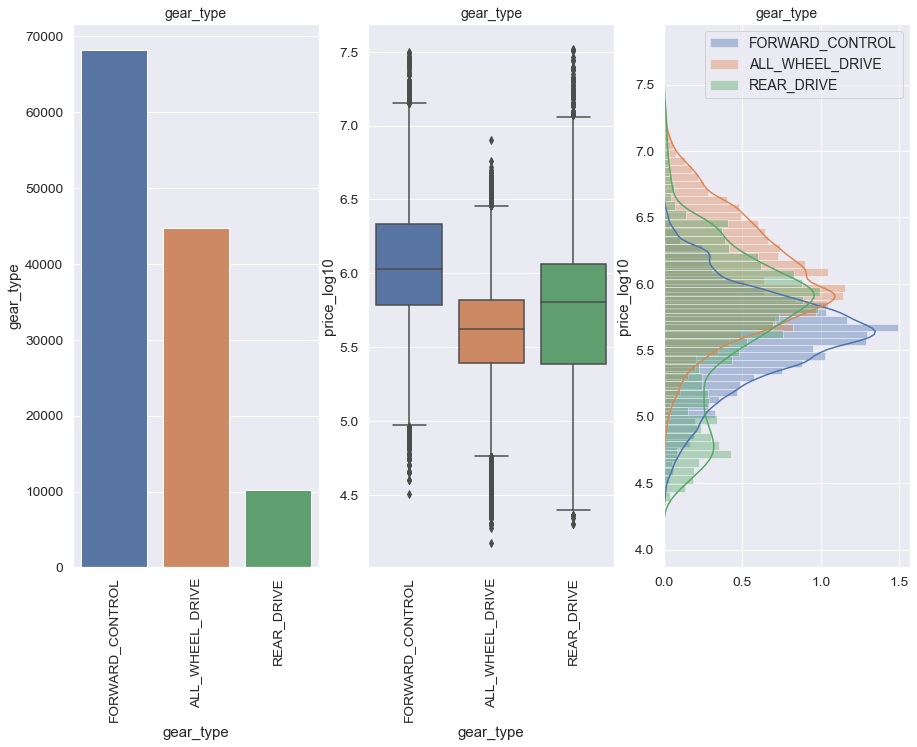

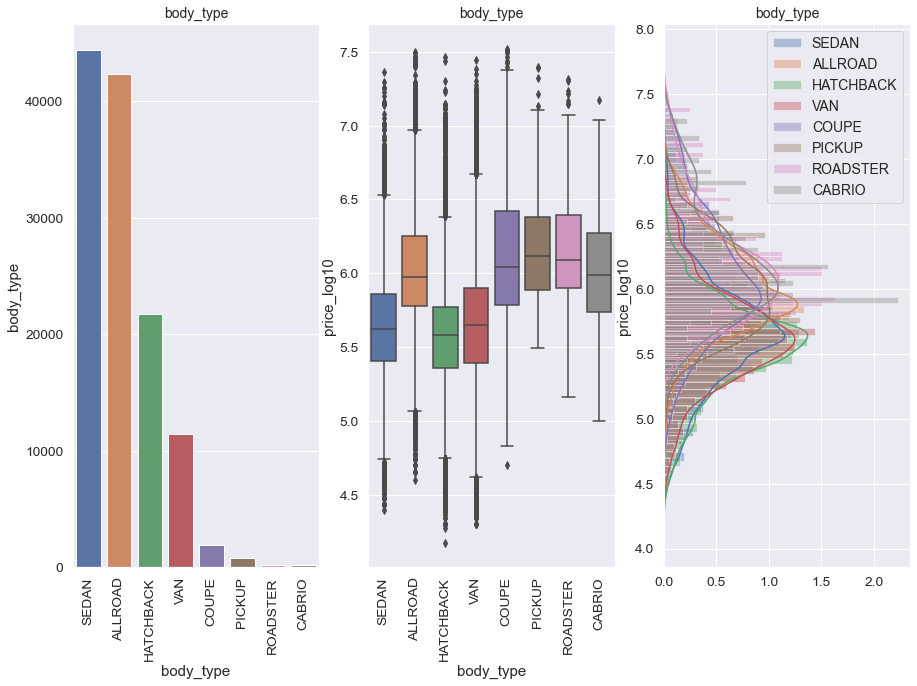

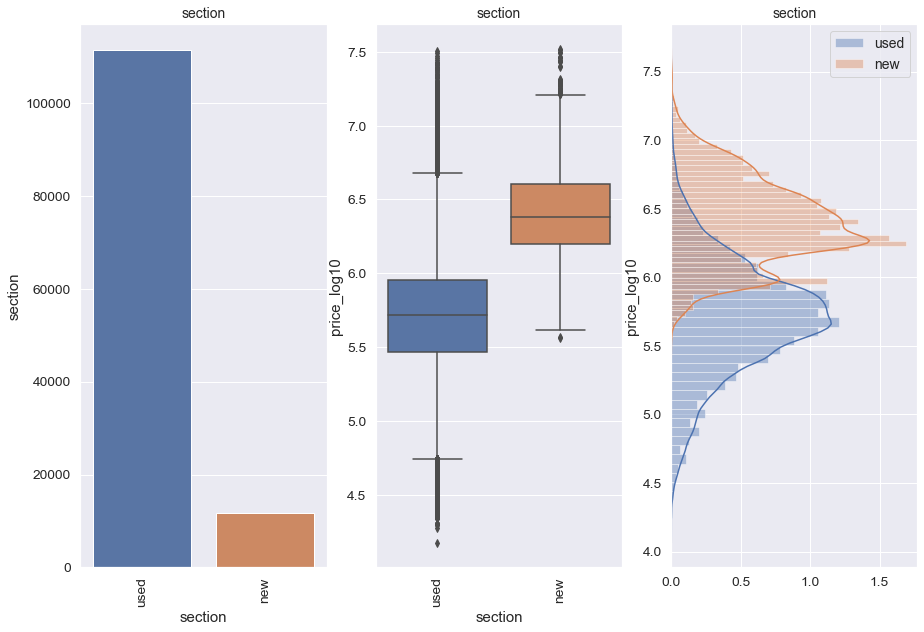

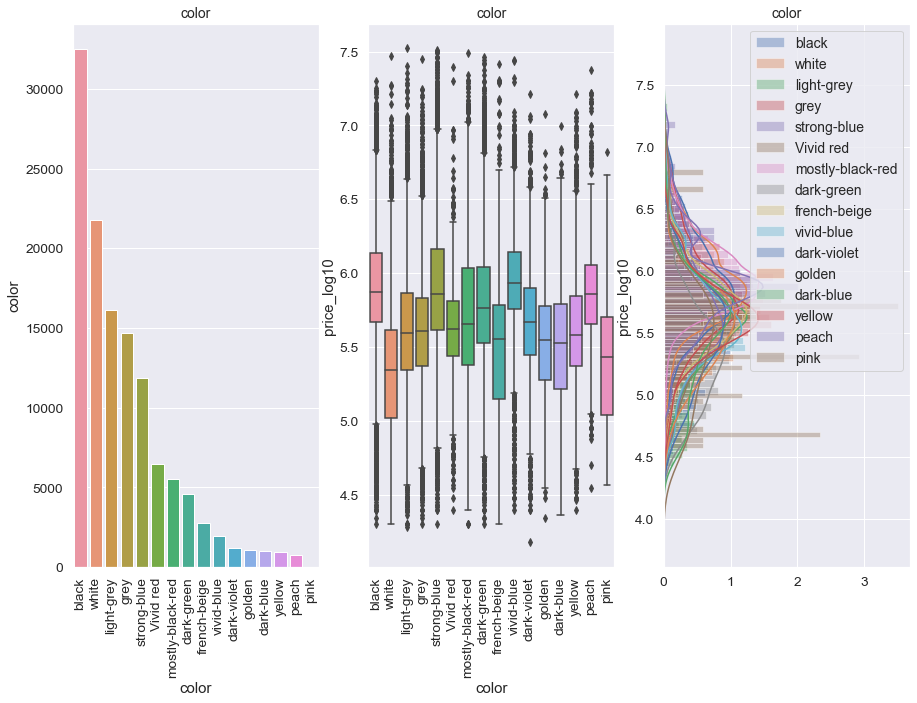

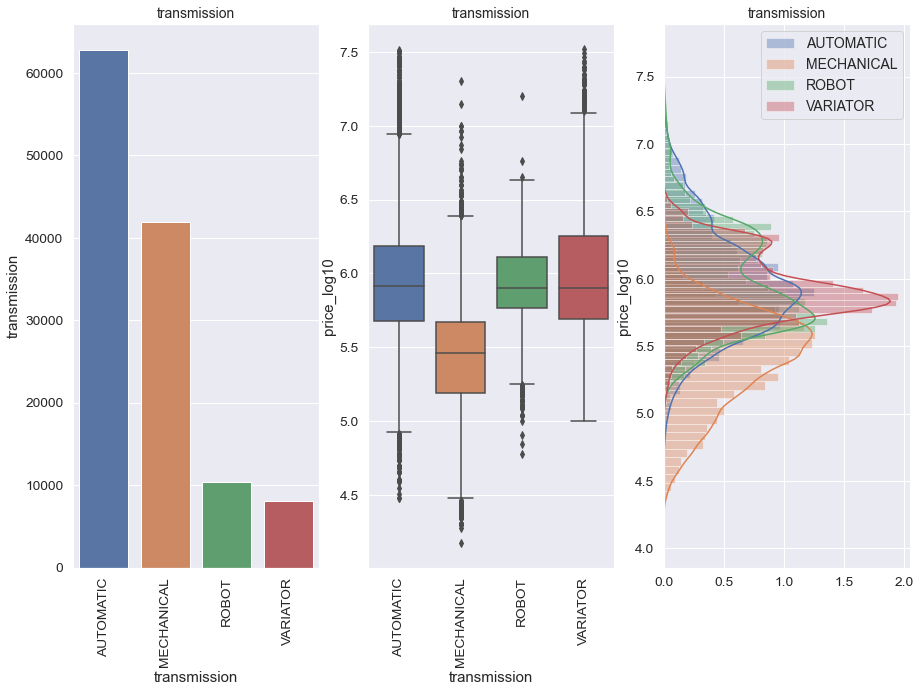

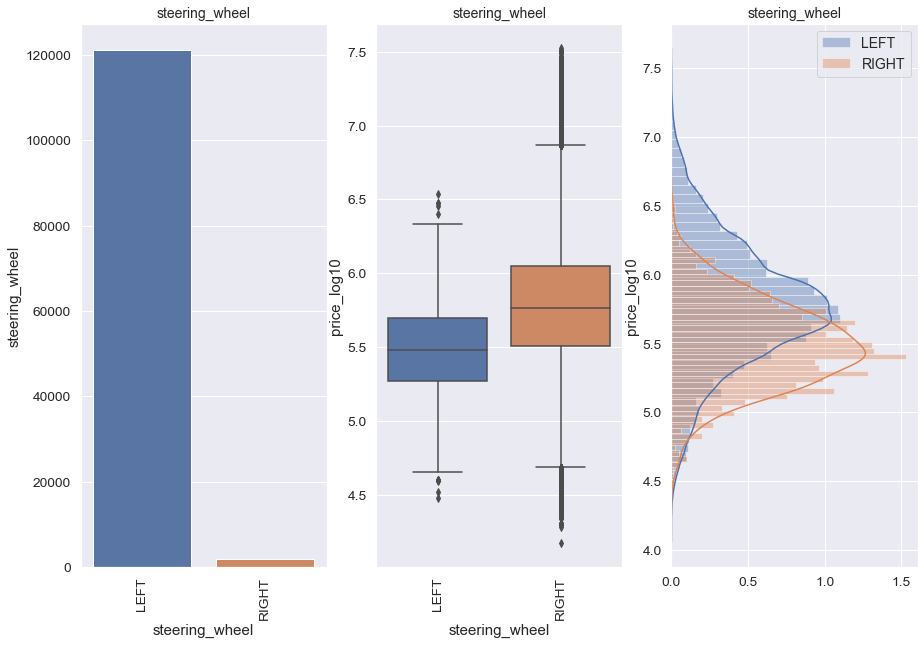

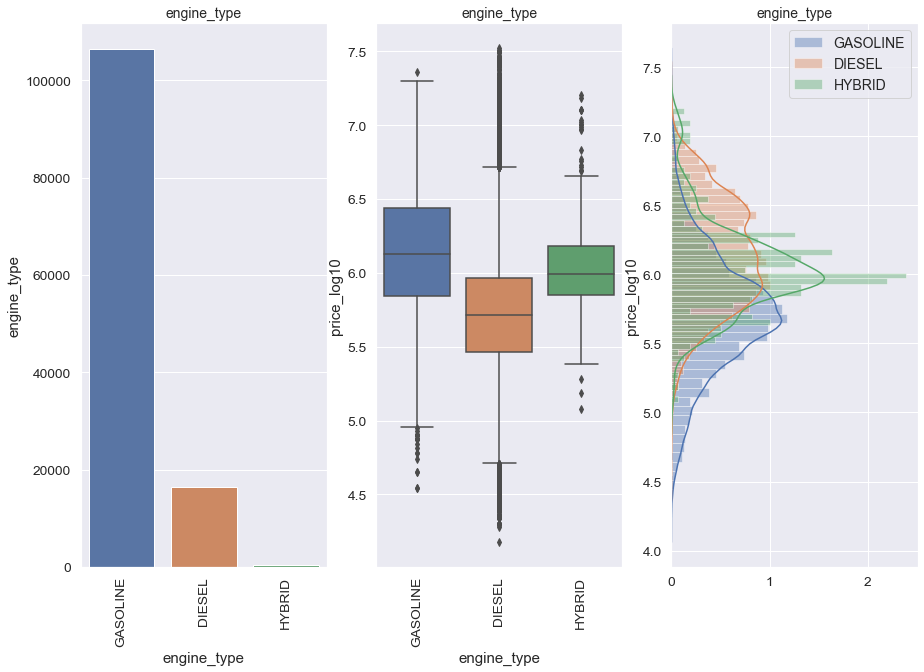

In [66]:
for item in features_one_hot_short:
    one_hot_variable_analysis(data, item, target_name, n_bins=50)

Вопиющих аномалий не видно.

In [67]:
# MARK: DATA TRANSFORMATION

# 4 Преобразование данных

In [68]:
data = data.drop(['price_log10'], axis=1)

target_name = 'price'

## 4.1 Преобразование типа данных

In [69]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123184 entries, 0 to 123202
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   body_type       123184 non-null  object 
 1   doors_count     123184 non-null  int64  
 2   mark            123184 non-null  object 
 3   model           123184 non-null  object 
 4   engine_type     123184 non-null  object 
 5   displacement    123184 non-null  int64  
 6   power           123184 non-null  int64  
 7   transmission    123184 non-null  object 
 8   gear_type       123184 non-null  object 
 9   steering_wheel  123184 non-null  object 
 10  color           123184 non-null  object 
 11  mileage         123184 non-null  int64  
 12  year            123184 non-null  int64  
 13  section         123184 non-null  object 
 14  owners          123184 non-null  float64
 15  price           123184 non-null  int64  
dtypes: float64(1), int64(6), object(9)
memory usage: 87.7 MB

In [70]:
data['owners'] = data['owners'].astype('int')
features_as_category = list( features_categorical_set - set(['doors_count', 'owners']) )

features_as_category

['gear_type',
 'mark',
 'body_type',
 'section',
 'model',
 'color',
 'transmission',
 'steering_wheel',
 'engine_type']

In [71]:
for item in features_as_category:
    data[item] = data[item].astype('category')
    
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123184 entries, 0 to 123202
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   body_type       123184 non-null  category
 1   doors_count     123184 non-null  int64   
 2   mark            123184 non-null  category
 3   model           123184 non-null  category
 4   engine_type     123184 non-null  category
 5   displacement    123184 non-null  int64   
 6   power           123184 non-null  int64   
 7   transmission    123184 non-null  category
 8   gear_type       123184 non-null  category
 9   steering_wheel  123184 non-null  category
 10  color           123184 non-null  category
 11  mileage         123184 non-null  int64   
 12  year            123184 non-null  int64   
 13  section         123184 non-null  category
 14  owners          123184 non-null  int32   
 15  price           123184 non-null  int64   
dtypes: category(9), int32(1), int64(6)
mem

## 4.2 Преобразование *One-Hot* переменных

*One-Hot* переменные преобразуем в *dummy*-переменные, откинув одну *dummy*-переменную во избежании *dummy*-ловушки.

In [72]:
data_model = data.copy()

In [73]:
# data_model = pd.get_dummies(data, columns=features_one_hot, drop_first=True).copy()
# data_model.columns
# data_model

## 4.3 Преобразование *Ordinal* переменных

Не требуется.

Поскольку LightGBM всегда говорит, что важность 'owners' равна нулю, выкинем и посмотрим что изменится без этого признака. 

Ответ: Стало хуже. Почему-то... Видимо, как-то всё же где-то учитывается

In [74]:
# data = data.drop(['owners'], axis=1)

In [75]:
print(features_ordinal)

# ord_encoder = OrdinalEncoder()

# data_ordinal = pd.DataFrame(ord_encoder.fit_transform(data_model[features_ordinal]), 
#                             columns=data_model[features_ordinal].columns, index=data_model.index)

data_model[features_ordinal]

['doors_count', 'owners']


doors_count  owners
0                 4       2
1                 3       2
2                 5       3
3                 3       1
4                 5       3
...             ...     ...
123198            5       1
123199            5       1
123200            5       1
123201            5       1
123202            3       3

[123184 rows x 2 columns]

In [76]:
# minmax_scaler = MinMaxScaler()
# data_scaled = minmax_scaler.fit_transform(data_ordinal)
# data_model[data_ordinal] = data_scaled

## 4.4 Масштабирование численных переменных

In [77]:
features_numerical

['displacement', 'power', 'mileage', 'year']

In [78]:
stand_scaler = StandardScaler()
stand_scaler.fit(data_model[features_numerical])
data_scaled = pd.DataFrame(stand_scaler.transform(data_model[features_numerical]), 
                          columns=data_model[features_numerical].columns, index=data_model.index, )
data_model[features_numerical] = data_scaled[features_numerical]
data_model

body_type  doors_count        mark       model engine_type  \
0             VAN            4      Nissan      Serena      DIESEL   
1         ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2       HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3       HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4       HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...           ...          ...         ...         ...         ...   
123198    ALLROAD            5         УАЗ     Patriot    GASOLINE   
123199    ALLROAD            5   Chevrolet        Niva    GASOLINE   
123200    ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
123201    ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
123202    ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement     power transmission        gear_type steering_wheel  \
0          -0.207046 -0.869096    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT   
1          -0.531495 -0.965773   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
2          -0.636970 -1.062449    AUTOMATIC  FORWARD_CONTROL           LEFT   
3          -1.724963 -1.618338   MECHANICAL  FORWARD_CONTROL           LEFT   
4           0.195363 -0.156109   MECHANICAL  FORWARD_CONTROL           LEFT   
...              ...       ...          ...              ...            ...   
123198      0.618407 -0.337377   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
123199     -0.531495 -1.002026   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
123200     -0.178385 -0.204447     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
123201      0.236635  0.049329     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
123202     -0.531495 -0.965773   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   

             color   mileage      year section  owners    price  
0            white  0.699901 -2.344623    used       2   195000  
1            white -1.023439 -2.024827    used       2   295000  
2       dark-green  0.952097 -2.184725    used       3   169000  
3        Vivid red -0.876324 -2.024827    used       1    26000  
4       light-grey  0.699901 -2.024827    used       3   145000  
...            ...       ...       ...     ...     ...      ...  
123198  light-grey -1.244110  1.173135    used       1   850000  
123199  dark-green -1.096996  1.173135    used       1   569000  
123200        grey -1.002423  1.173135    used       1  1650000  
123201       white -0.804869  1.173135    used       1  1850000  
123202       black -1.181061  1.173135    used       3   510000  

[123184 rows x 16 columns]

In [79]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:00:46.666    (H:MM:SS)


<div class="alert alert-block alert-success">
<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">
Отсюда начинается этап моделирования</h1>


IGNITION SEQUENCE START

</div>

Обучим следующие модели модели:
- Решающее дерево
- Случайный лес
- CatBoostRegressor 
- LightGBM

# 5 Prelaunch

## 5.0 Functions for target transformation

$$z = \log_{10}y$$

$${\rm transform:}\qquad s = z^{1/p} = (\log_{10}y)^{1/p}$$

$${\rm inverse transform:}\qquad y = 10^{p^y}$$

In [80]:
def sqrtn(x, power):
    ans = []
    for z in x:
        if z >= 0:
            ans.append( z**(1/power) )
        else:
            ans.append( -np.abs(z)**(1/power) )
    return np.array(ans)
    


def target_transform(y, p):
    z = np.log10(y)
    s = sqrtn(z, p)
    return s



def target_transform_inv(s, p):
    z = s**p
    y = 10**z
    return y

## 5.1 Metrics function (MAPE)

In [81]:
import numpy as np
def mean_absolute_percent_error(y_true, y_pred):
    
    """
    The mean absolute percentage error (MAPE).
    Note 1: Here MAPE is measured in %%.
    Note 2: The zero values of y_true are ignored.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs( (y_true - y_pred) / y_true) ) * 100

# mape_scorer = make_scorer(mean_absolute_percent_error, greater_is_better=False)

## 5.2 Features and target. Samples.

In [82]:
frac = FRAC

print("There are {} entities in whole dataset.".format(len(data)))

data_whole = data.copy()
# data_whole = data_model.copy()
data = data_whole.sample(frac=frac, random_state=RANDOM_STATE)


data_1_2, data_test = train_test_split(data, test_size=1/9,random_state=RANDOM_STATE)
data_1, data_2 = train_test_split(data_1_2, test_size=0.5, random_state=RANDOM_STATE)
data_train1, data_valid1 = train_test_split(data_1, test_size=0.25, random_state=RANDOM_STATE)
data_train2, data_valid2 = train_test_split(data_2, test_size=0.25, random_state=RANDOM_STATE)


del data_1_2

print("We took {} entities now."
      .format( len(data) ))
print("We took {} entities for `train1` dataset and {} entities for valid1 dataset.\n"
      .format( len(data_train1), len(data_valid1) ))

print("The target values in `train1` are in range      [{}, {}] "
      .format( data_train1[target_name].min(), data_train1[target_name].max() ))
print("The target values in `valid1` are in range      [{}, {}] "
      .format( data_valid1[target_name].min(), data_valid1[target_name].max() ))
print("The target values in whole dataset are in range [{}, {}] "
      .format( data_whole[target_name].min(), data_whole[target_name].max() ))

There are 123184 entities in whole dataset.
We took 123184 entities now.
We took 41061 entities for `train1` dataset and 13687 entities for valid1 dataset.

The target values in `train1` are in range      [15000, 32520000] 
The target values in `valid1` are in range      [20000, 31310000] 
The target values in whole dataset are in range [15000, 33277000] 


The maximal relative error of target transformation = 5.092646145452099e-15


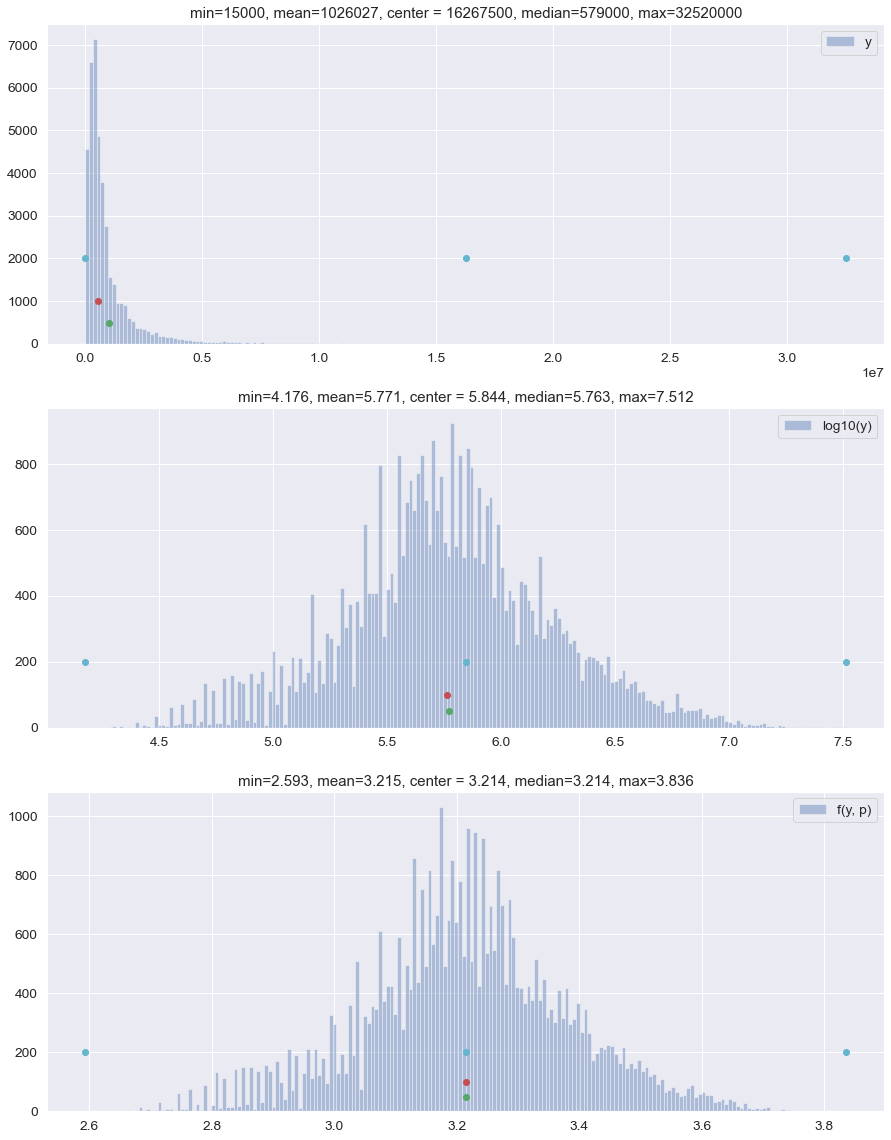

In [83]:
y = data_train1[target_name]

p = 1.5
z = target_transform(y, p)
s = target_transform_inv(z, p)


n_bins = 200

plt.subplots(3, 1, figsize=(15, 20))

plt.subplot(3, 1, 1)
level = 1000
sns.distplot(y, bins=n_bins, kde=False, label='y')
plt.plot(y.min(), 2*level, 'co')
plt.plot(y.mean(), level/2, 'go')
plt.plot(np.median(y), level, 'ro')
plt.plot(y.max(), 2*level, 'co')
plt.plot((y.max()+y.min())/2, 2*level, 'co')
plt.title("min={}, mean={:.0f}, center = {:.0f}, median={:.0f}, max={}"
          .format(y.min(), y.mean(), (y.max()+y.min())/2, np.median(y), y.max()))
plt.legend()
plt.xlabel('')

y_log = np.log10(y)

plt.subplot(3, 1, 2)
level = 100
sns.distplot(y_log, bins=n_bins, kde=False, label='log10(y)')
plt.plot(y_log.min(), 2*level, 'co')
plt.plot(y_log.mean(), level/2, 'go')
plt.plot(np.median(y_log), level, 'ro')
plt.plot((y_log.max()+y_log.min())/2, 2*level, 'co')
plt.plot(y_log.max(), 2*level, 'co')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(y_log.min(), y_log.mean(), (y_log.max()+y_log.min())/2, np.median(y_log), y_log.max()))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 3)
level = 100
sns.distplot(z, bins=n_bins, kde=False, label='f(y, p)')
plt.plot(z.min(), 2*level, 'co')
plt.plot(z.mean(), level/2, 'go')
plt.plot(np.median(z), level, 'ro')
plt.plot(z.max(), 2*level, 'co')
plt.plot((z.max()+z.min())/2, 2*level, 'co')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(z.min(), z.mean(), (z.max()+z.min())/2, np.median(z), z.max()))
plt.legend()
plt.xlabel('')

print("The maximal relative error of target transformation =",
      ( np.abs( target_transform_inv(target_transform(y, p), p) - y )/y ).max())

### 5.3 Model optimizer

In [84]:
data_train1[target_name]

45420      435000
59504     1000000
118014     150000
19617      209000
96007      610000
           ...   
11920     3299000
72296     3400000
52069     3465000
9697      4399000
104922      85000
Name: price, Length: 41061, dtype: int64

In [85]:
np.log10(data_train1[target_name])

45420     5.638489
59504     6.000000
118014    5.176091
19617     5.320146
96007     5.785330
            ...   
11920     6.518382
72296     6.531479
52069     6.539703
9697      6.643354
104922    4.929419
Name: price, Length: 41061, dtype: float64

In [86]:
def model_one_coord_search(EstimatorClass, params_fixed, params_limits, 
                           data_trr, data_vall, target_name, n_sample, 
                           num_points=21, metrics_func=None,
                           lgb_categorical_feature_list='auto',
                           verbose=False, visualize=False):
    """
    This FUNCTION 
    - creates the model;
    - trains it with the train data;
    - makes the prediction from valid data;
    - calculate metrics and
    - measures the time of performance of all above actions.
    
    NOTE:
    ...
    ...LighnGBM (marked as 'lgb')
    
    INPUT:
    
    
    OUTPUT:
    
    Version 1.1
    Needs libraries:
    - pandas
    - numpy
    - scikit-learn
    - time
    
    """
    
    
    
    param_current = params_fixed.copy()

    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=param_current['random_state'])
        
    ### target transformation
    ###
#     data_tr[target_name] = np.log10(data_tr[target_name])  ## log10-transformation
    data_tr[target_name] = target_transform(data_tr[target_name], POWER)
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
    
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    
    for key in params_limits.keys():
        if params_limits[key][2] == 'int':
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points, dtype=int)
        else:
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points)
                        
        param_range = np.unique(param_range)
        
        metrics_list = []
        performance_list = []
        metrics_best = 10**10
        best_param = None
        
        for k, point in enumerate(param_range):
            param_current[key] = point
            
            ### ** - The best way to initialise estimator with the parameters
            ### would be to unpack dictionary
            if EstimatorClass != 'lgbm':
                t0 = time.time()
                model = EstimatorClass(**param_current)
                model.fit(feat_train, targ_train)
            else:
                # We should give LightGBM data converted to his own form 
                # Here data is pandas.DataFrame with catecorical data, label is target
                train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                          categorical_feature=lgb_categorical_feature_list)
                t0 = time.time()
                model = lgbm.train(param_current, train_data)
                
            ### target inverse transformation
            ###
#             prediction = model.predict(feat_valid)
#             prediction_log10 = model.predict(feat_valid)
            prediction_transformed = model.predict(feat_valid)
            prediction = target_transform_inv(prediction_transformed, POWER)
        
            
            metrics = metrics_func(targ_valid, prediction)
            metrics_list.append(metrics)
            
            if metrics < metrics_best:
                metrics_best = metrics
                best_param = point
            
            performance_time = time.time() - t0
            performance_list.append(performance_time)
            
            if verbose:
                print("{} : {} = {:.6f} : METRICS = {:.4f} ; eval_time = {:.3f} sec"
                      .format( k, key, point, metrics, performance_time ))
        
        metrics_array = np.array(metrics_list)
        performance_array = np.array(performance_list)
        
        if visualize:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
            plt.plot(best_param, metrics_best, 'o', markersize=14, 
                     markerfacecolor='w', markeredgecolor='r', label="best point")
            plt.plot(param_range, metrics_array, '-bo', label="")
            plt.legend()
            plt.title("The best metrics is {:.4f} for {}={}"
                      .format( metrics_best, key, best_param ))
        
    return metrics_array, param_range, performance_array, best_param, metrics_best

Test of `model_one_coord_search` (Stage 1)

In [87]:
features_categorical

['doors_count',
 'engine_type',
 'mark',
 'owners',
 'body_type',
 'section',
 'model',
 'color',
 'transmission',
 'steering_wheel',
 'gear_type']

In [88]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}
param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False
param_dict_fix['n_estimators'] = 300
param_dict_fix['learning_rate'] = 0.01

# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit

### variable parameters

params_lim = {}
# params_lim['n_estimators'] = [2, 1000, 'int']
# params_lim['learning_rate'] = [0.001, 2, 'float']
params_lim['max_depth'] = [2, 22, 'int']

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0 : max_depth = 2.000000 : METRICS = 27.5865 ; eval_time = 0.529 sec
1 : max_depth = 3.000000 : METRICS = 22.0544 ; eval_time = 0.560 sec
2 : max_depth = 4.000000 : METRICS = 18.9940 ; eval_time = 0.692 sec
3 : max_depth = 5.000000 : METRICS = 17.3739 ; eval_time = 1.010 sec
4 : max_depth = 6.000000 : METRICS = 17.0338 ; eval_time = 1.412 sec
5 : max_depth = 7.000000 : METRICS = 16.9201 ; eval_time = 1.158 sec
6 : max_depth = 8.000000 : METRICS = 16.9003 ; eval_time = 1.215 sec
7 : max_depth = 9.000000 : METRICS = 16.9070 ; eval_time = 1.283 sec
8 : max_depth = 10.000000 : METRICS = 16.9064 ; eval_time = 1.235 sec
9 : max_depth = 11.000000 : METRICS = 16.9064 ; eval_time = 1.295 sec
10 : max_depth = 12.000000 : METRICS = 16.9064 ; eval_time = 1.215 sec
11 : max_depth = 13.000000 : METRICS = 16.9064 ; eval_time = 1.364 sec
12 : max_depth = 14.000000 : METRICS = 16.9064 ; eval_time = 1.536 sec
13 : max_depth = 15.000000 : METRICS = 16.9064 ; eval_time = 1.255 sec
14 : max_depth = 16.0000

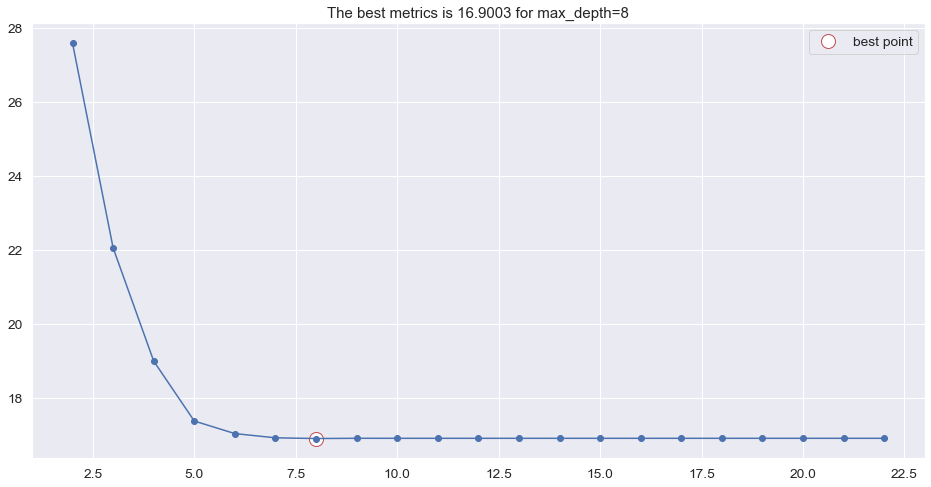

In [89]:
### TEST OF ONE COORDINATE SEARCH

result = model_one_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                                data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                                metrics_func=mean_absolute_percent_error,
                                lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                                verbose=True, visualize=True)

metrics_array, param_range, performance_array, best_param, metrics_best = result

print()
print("metrics_array:", metrics_array)
print()

print("param_range:", param_range)
print()

print("performance_array:", performance_array)
print()

print("best_param =", best_param)
print()

print("metrics_best =", metrics_best)
print()

In [90]:
def model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                            data_tr, data_val, target_name, n_sample, 
                            num_points=21, metrics_func=None,
                            lgb_categorical_feature_list='auto',
                            verbose=False, visualize=False):
    
    
    param_current = params_fixed.copy()
    
    best_param_loop = {}
    metrics_best_loop = 10**10
    
    param_lim_1 = {}
    result_dict = {}
    for key in params_limits.keys():
        param_lim_1[key] = params_limits[key]
        if verbose:
            print()
            print("^^^")
            print("Fixed", param_current)
            print("Varies", param_lim_1)
            print("^^^\n")
        result = model_one_coord_search(EstimatorClass, param_current, param_lim_1, 
                                        data_tr, data_val, target_name, n_sample, 
                                        num_points=num_points, metrics_func=metrics_func,
                                        lgb_categorical_feature_list=lgb_categorical_feature_list,
                                        verbose=verbose, visualize=visualize)
        metrics_array, param_range, performance_array, best_param, metrics_best = result
        
        if best_param < metrics_best_loop:
            metrics_best_loop = best_param
        
        param_current[key] = best_param
        result_dict[key] = best_param
        param_lim_1 = {}
        
        if verbose:
            print()
            print("*** Best {} = {} witn METRICS = {}".format(key, best_param, metrics_best))
        
    return result_dict, metrics_best

Test of `model_coord_search_loop` (Stage 2)

In [91]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False


param_dict_fix['n_estimators'] = 300
param_dict_fix['learning_rate'] = 0.01
param_dict_fix['max_depth'] = 8 ##
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit





### variable parameters

params_lim = {}
params_lim['n_estimators'] = [2, 100, 'int']
params_lim['max_depth'] = [2, 22, 'int']
params_lim['learning_rate'] = [0.001, 2.001, 'float']


^^^
Fixed {'objective': 'mse', 'random_state': 1607, 'free_raw_data': False, 'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 8}
Varies {'n_estimators': [2, 100, 'int']}
^^^

0 : n_estimators = 2.000000 : METRICS = 117.5915 ; eval_time = 0.143 sec

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



1 : n_estimators = 6.000000 : METRICS = 110.6852 ; eval_time = 0.191 sec
2 : n_estimators = 11.000000 : METRICS = 102.9076 ; eval_time = 0.202 sec
3 : n_estimators = 16.000000 : METRICS = 96.0097 ; eval_time = 0.203 sec
4 : n_estimators = 21.000000 : METRICS = 89.7963 ; eval_time = 0.221 sec
5 : n_estimators = 26.000000 : METRICS = 84.2477 ; eval_time = 0.256 sec
6 : n_estimators = 31.000000 : METRICS = 79.1945 ; eval_time = 0.258 sec
7 : n_estimators = 36.000000 : METRICS = 74.5947 ; eval_time = 0.273 sec
8 : n_estimators = 41.000000 : METRICS = 70.4151 ; eval_time = 0.300 sec
9 : n_estimators = 46.000000 : METRICS = 66.5947 ; eval_time = 0.334 sec
10 : n_estimators = 51.000000 : METRICS = 63.1155 ; eval_time = 0.411 sec
11 : n_estimators = 55.000000 : METRICS = 60.5019 ; eval_time = 0.420 sec
12 : n_estimators = 60.000000 : METRICS = 57.4869 ; eval_time = 0.457 sec
13 : n_estimators = 65.000000 : METRICS = 54.7120 ; eval_time = 0.470 sec
14 : n_estimators = 70.000000 : METRICS = 52.

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0 : max_depth = 2.000000 : METRICS = 55.4425 ; eval_time = 0.338 sec
1 : max_depth = 3.000000 : METRICS = 47.8320 ; eval_time = 0.313 sec
2 : max_depth = 4.000000 : METRICS = 43.3614 ; eval_time = 0.521 sec
3 : max_depth = 5.000000 : METRICS = 40.6917 ; eval_time = 0.454 sec
4 : max_depth = 6.000000 : METRICS = 40.1884 ; eval_time = 0.573 sec
5 : max_depth = 7.000000 : METRICS = 40.0638 ; eval_time = 0.775 sec
6 : max_depth = 8.000000 : METRICS = 40.0733 ; eval_time = 0.510 sec
7 : max_depth = 9.000000 : METRICS = 40.0733 ; eval_time = 0.522 sec
8 : max_depth = 10.000000 : METRICS = 40.0733 ; eval_time = 0.525 sec
9 : max_depth = 11.000000 : METRICS = 40.0733 ; eval_time = 0.478 sec
10 : max_depth = 12.000000 : METRICS = 40.0733 ; eval_time = 0.482 sec
11 : max_depth = 13.000000 : METRICS = 40.0733 ; eval_time = 0.479 sec
12 : max_depth = 14.000000 : METRICS = 40.0733 ; eval_time = 0.572 sec
13 : max_depth = 15.000000 : METRICS = 40.0733 ; eval_time = 0.544 sec
14 : max_depth = 16.0000

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0 : learning_rate = 0.001000 : METRICS = 104.4587 ; eval_time = 0.676 sec
1 : learning_rate = 0.101000 : METRICS = 14.5439 ; eval_time = 0.503 sec
2 : learning_rate = 0.201000 : METRICS = 14.5771 ; eval_time = 0.511 sec
3 : learning_rate = 0.301000 : METRICS = 14.7719 ; eval_time = 0.637 sec
4 : learning_rate = 0.401000 : METRICS = 15.1067 ; eval_time = 0.452 sec
5 : learning_rate = 0.501000 : METRICS = 15.3984 ; eval_time = 0.399 sec
6 : learning_rate = 0.601000 : METRICS = 15.8878 ; eval_time = 0.471 sec
7 : learning_rate = 0.701000 : METRICS = 16.0917 ; eval_time = 0.490 sec
8 : learning_rate = 0.801000 : METRICS = 16.6358 ; eval_time = 0.514 sec
9 : learning_rate = 0.901000 : METRICS = 17.3860 ; eval_time = 0.512 sec
10 : learning_rate = 1.001000 : METRICS = 17.6715 ; eval_time = 0.459 sec
11 : learning_rate = 1.101000 : METRICS = 18.5086 ; eval_time = 0.438 sec
12 : learning_rate = 1.201000 : METRICS = 19.7386 ; eval_time = 0.475 sec
13 : learning_rate = 1.301000 : METRICS = 20.25

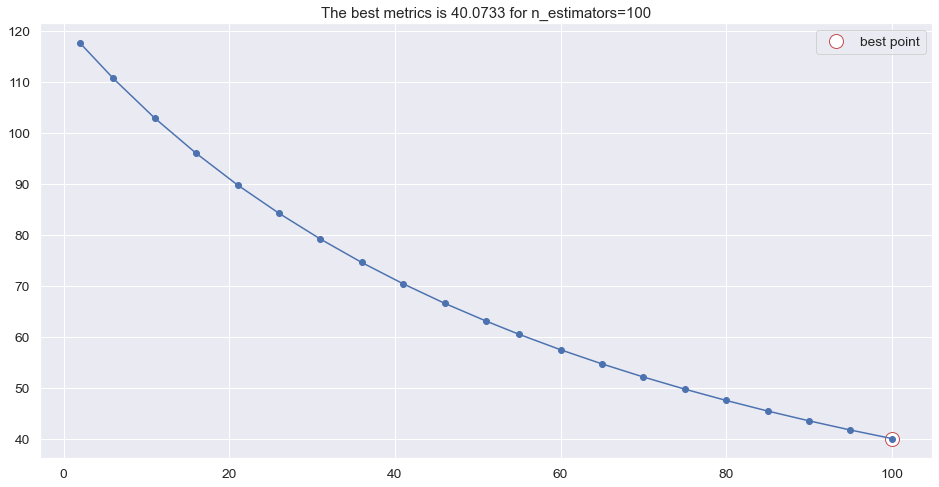

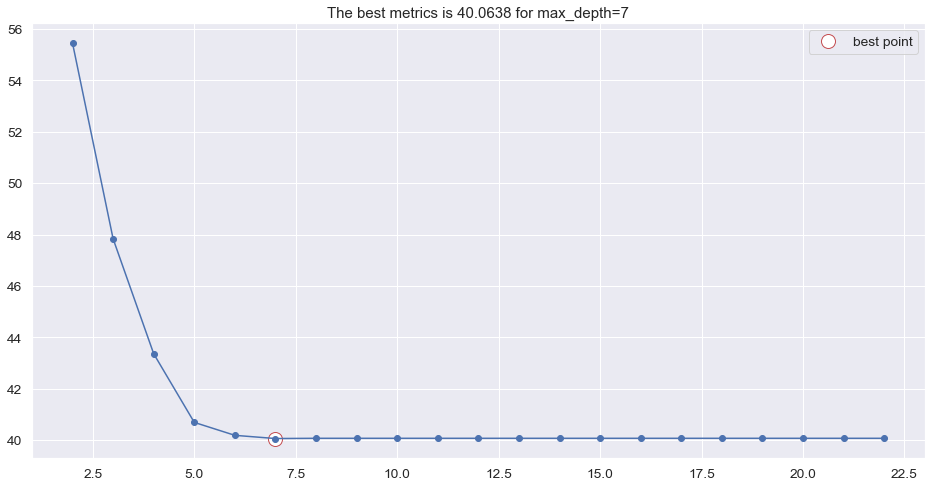

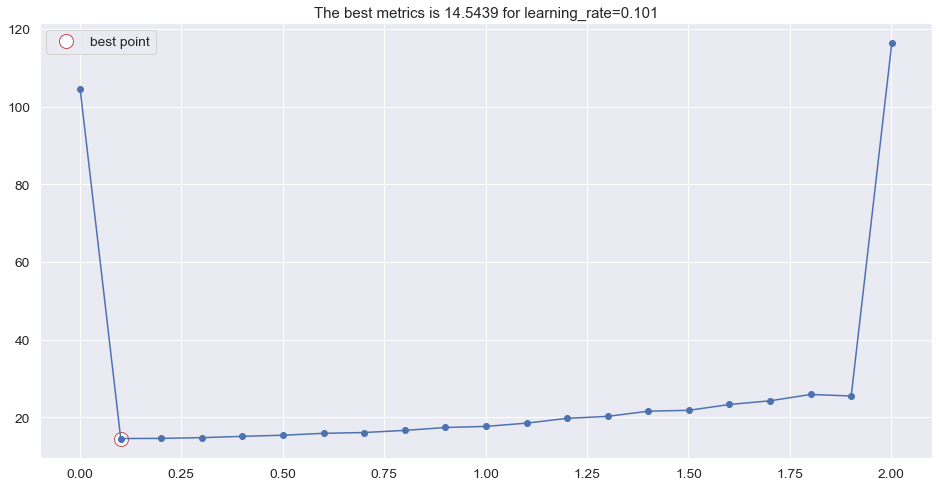

In [92]:
result = model_coord_search_loop(EstimatorClass, param_dict_fix, params_lim, 
                                 data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                                 metrics_func=mean_absolute_percent_error,
                                 lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                                 verbose=True, visualize=True)

result_dict, metrics_best = result

print("***")
print("*** result_dict :", result_dict)
print("*** metrics_best =", metrics_best)
print("***")

In [93]:
def model_coord_search(EstimatorClass, params_fixed, params_limits, 
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False):
    
    """
    This fuction performs the search of the best parameters over specified parameter values 
    for an estimator using coordinate search.
    
    PARAMETERS:
        
    EstimatorClass - estimator object. 
        This is assumed to implement the scikit-learn estimator interface with `fit` and `predict` methods. 
        LightGBM is a special case - you should define EstimatorClass as a string 'lgbm' and
        `import lightgbm as lgbm` .
    
    params_fixed - dict. 
        Dictionary with parameters names (str) as keys and lists of parameter settings to try. 
        Such a list contains three elements: 
            First - the minimal limit for the parameter grid ('int' or 'float')
            Second - the maximal limit for the parameter grid ('int' or 'float')
            Third - the type of variable (str: 'int' or 'float'). The string which is not 'int' treated as 'float'.    
    
    params_limits - dict.
    
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False
    """
    
    metrics_in = 10**10
    metrics_out = 10**9
    
    metrics_best = 10**10
    best_params = {}
    
    k = 0
    metrics_to_plot = []
    while metrics_in - metrics_out >= tol: 
        t0 = time.time()
        if verbose_cycle:
            print("[{}]".format(k))
            print("params_limits :", params_limits)
            
        metrics_in = metrics_out        
        result_dict, metrics_out = model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                                                            data_tr, data_val, target_name, n_sample, 
                                                            num_points=num_points, metrics_func=metrics_func,
                                                            lgb_categorical_feature_list='auto',
                                                            verbose=verbose_detail, visualize=visualize_detail)
        if metrics_out < metrics_best:
            metrics_best = metrics_out
            best_params = result_dict
        
        
        metrics_to_plot.append(metrics_out)
        
        for key in params_limits.keys():
            step_key = ( params_limits[key][1] - params_limits[key][0] ) / ( num_points - 1 )
            if params_limits[key][2] == 'int':
                step_key = int(np.ceil(step_key))
                
            lim_min = result_dict[key] - step_key
            if lim_min < params_limits[key][0]:
                lim_min = params_limits[key][0]
            lim_max = result_dict[key] + step_key
            params_limits[key] = [ lim_min, lim_max, params_limits[key][2] ]
            
        
        if verbose_cycle:
            print("OUT [{}]: M(i) = {:.6f}; M(i+1) = {:.6f} (tol={})"
                  .format(k, metrics_in, metrics_out, tol))
            print("result_dict", result_dict)
            print("Iteration time = {:.2f} sec".format( time.time() - t0 ))
            print("\n", "~ "*9, "\n")
        k += 1
        if k > iter_lim:
            print("The limit of iterations is achieved. Sorry!")
            break
            
    print(min(metrics_to_plot))
    if visualize_cycle:        
        shift = 0.03*(max(metrics_to_plot) - min(metrics_to_plot))
        x = np.arange(0, len(metrics_to_plot))
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        plt.plot(x, metrics_to_plot, '-bo')
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Metrics", fontsize=14)
        for a, b in zip(x, metrics_to_plot): 
            plt.text(a, b+shift, str( np.round(b, 4)), fontsize=12)
        plt.show()
    
    print()
    print("Done. Congratulations!")
    
    return best_params, metrics_best

# 6 Optimization of base models

### LightGBM with default parameters

In [94]:
param_current = {}

data_tr_unopt = data_train1.copy()
data_val_unopt = data_valid1.copy()

data_tr_unopt[target_name] = np.log10(data_tr_unopt[target_name])
data_val_unopt[target_name] = np.log10(data_val_unopt[target_name])

train_data = lgbm.Dataset(data_tr_unopt.drop([target_name], axis=1), label=data_tr_unopt[target_name])

model = lgbm.train(param_current, train_data)
# prediction = model.predict(data_val_unopt.drop([target_name], axis=1))
prediction_log10 = model.predict(data_val_unopt.drop([target_name], axis=1))
prediction = 10**prediction_log10
mape_unoptimized = mean_absolute_percent_error(data_valid1[target_name], prediction)

print("We have MAPE={:.4f} for unoptimized model.".format(mape_unoptimized))

We have MAPE=14.5330 for unoptimized model.


In [95]:
data_train1[target_name], data_tr_unopt[target_name], [1139000, 175000], np.log10(np.array([1139000, 175000]))

(45420      435000
 59504     1000000
 118014     150000
 19617      209000
 96007      610000
            ...   
 11920     3299000
 72296     3400000
 52069     3465000
 9697      4399000
 104922      85000
 Name: price, Length: 41061, dtype: int64,
 45420     5.638489
 59504     6.000000
 118014    5.176091
 19617     5.320146
 96007     5.785330
             ...   
 11920     6.518382
 72296     6.531479
 52069     6.539703
 9697      6.643354
 104922    4.929419
 Name: price, Length: 41061, dtype: float64,
 [1139000, 175000],
 array([6.05652372, 5.24303805]))

<div class="alert alert-block alert-success">
<div style="border:solid green 2px; padding: 20px"> <h2 style="color:green; margin-bottom:20px">
6.1 Optimization of base models (*LGBMRegressor*)</h2>

</div>

- [Basic info](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor)

In [96]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}
param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False


param_dict_fix['n_estimators'] = 300
param_dict_fix['learning_rate'] = 0.01
param_dict_fix['max_depth'] = 9
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit





### variable parameters

params_lim = {}

params_lim['n_estimators'] = [2, 3000, 'int']
params_lim['max_depth'] = [2, 102, 'int']
params_lim['learning_rate'] = [0.0001, 2.0001, 'float']

# params_lim['n_estimators'] = [2260, 2265, 'int'] ##2264
# params_lim['max_depth'] = [10, 16, 'int'] ## 12
# params_lim['learning_rate'] = [0.08, 0.1, 'float'] ## 0.0891

[0]
params_limits : {'n_estimators': [2, 3000, 'int'], 'max_depth': [2, 102, 'int'], 'learning_rate': [0.0001, 2.0001, 'float']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 14.336622 (tol=0.0001)
result_dict {'n_estimators': 3000, 'max_depth': 17, 'learning_rate': 0.10010000000000001}
Iteration time = 563.90 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [2850, 3150, 'int'], 'max_depth': [12, 22, 'int'], 'learning_rate': [0.00010000000000000286, 0.2001, 'float']}
OUT [1]: M(i) = 14.336622; M(i+1) = 13.890902 (tol=0.0001)
result_dict {'n_estimators': 3135, 'max_depth': 16, 'learning_rate': 0.030100000000000002}
Iteration time = 549.03 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[2]
params_limits : {'n_estimators': [3120, 3150, 'int'], 'max_depth': [15, 17, 'int'], 'learning_rate': [0.0201, 0.040100000000000004, 'float']}
OUT [2]: M(i) = 13.890902; M(i+1) = 13.866126 (tol=0.0001)
result_dict {'n_estimators': 3129, 'max_depth': 16, 'learning_rate': 0.0211}
Iteration time = 471.89 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[3]
params_limits : {'n_estimators': [3127, 3131, 'int'], 'max_depth': [15, 17, 'int'], 'learning_rate': [0.02

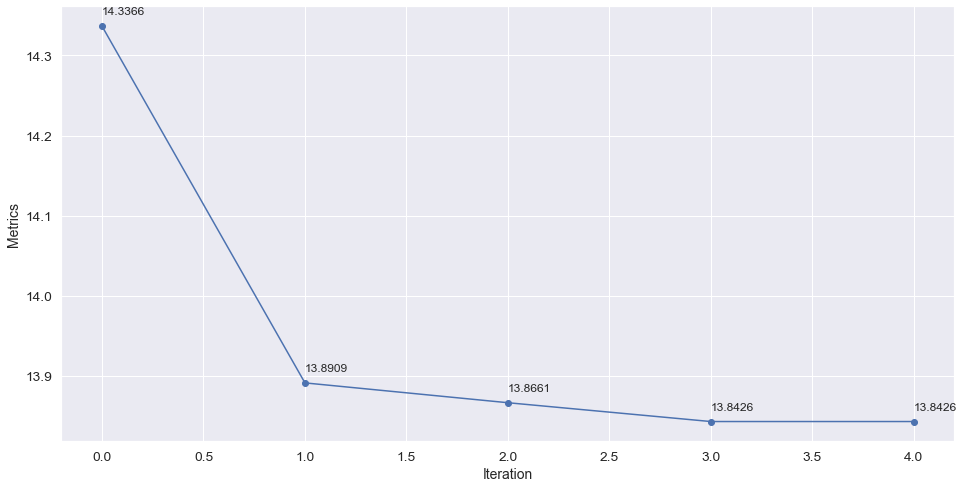


Done. Congratulations!
[***] This is Houston. The MET is : 0:37:48.890    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best base model are:  {'n_estimators': 3131, 'max_depth': 16, 'learning_rate': 0.0208}
The best base model has MAPE=13.8426
Wall time: 36min


In [97]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                            num_points=21,
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best base model are: ", result_dict)
print("The best base model has MAPE={:.4f}".format(metrics_out))

In [98]:
best_model_1_mape = metrics_out
best_parameters = result_dict
print("The best parameters for the base model are: ", best_parameters)
print("We have the MAPE = {:.4f} for the best base model. ".format(best_model_1_mape))

The best parameters for the base model are:  {'n_estimators': 3131, 'max_depth': 16, 'learning_rate': 0.0208}
We have the MAPE = 13.8426 for the best base model. 


In [99]:
def model_collector(EstimatorClass, params_fixed, params_opt, 
                    data_trr, data_vall, target_name, n_sample,
                    metrics_func=None,
                    lgb_categorical_feature_list='auto'):
    
    """
    """
    
    
    import itertools
    
    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=params_fixed['random_state'])
    
    data_tr[target_name] = np.log10(data_tr[target_name])
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
        
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    result_df = pd.DataFrame( columns=list(params_opt.keys())+["metrics", "performance_time", "model"] )
    print(list(result_df.columns))
    
    keys, values = zip(*params_opt.items())
    ## list of dicts
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for k, dict_point in enumerate(permutations_dicts):
        param_current = {**params_fixed, **dict_point}
        
        if EstimatorClass != 'lgbm':
            t0 = time.time()
            model = EstimatorClass(**param_current)
            model.fit(feat_train, targ_train)
        else:
            # We should give LightGBM data converted to his own form 
            # Here data is pandas.DataFrame with catecorical data, label is target
            train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                      categorical_feature=lgb_categorical_feature_list)
            t0 = time.time()
            model = lgbm.train(param_current, train_data)
                
#         prediction = model.predict(feat_valid)
        prediction_log10 = model.predict(feat_valid)
        prediction = 10**prediction_log10
        metrics = metrics_func(targ_valid, prediction)
        
        performance_time = time.time() - t0
        
        list_to_append = list( dict_point.values() ) + [metrics, performance_time, model]
        print(list_to_append)
        result_df = result_df.append(pd.DataFrame([list_to_append], columns=result_df.columns), ignore_index=True)
        
    result_df = result_df.sort_values('metrics', ascending=True).reset_index(drop=True)
        
    return result_df

In [100]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}
param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters

n_es_0 = best_parameters['n_estimators']
md_0 = best_parameters['max_depth']
lr_0 = np.round(best_parameters['learning_rate'], 9)

params_optim = {}
params_optim['n_estimators'] =  [max([2, n_es_0-STEP_INT]), n_es_0, n_es_0+STEP_INT ]
params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]
params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]

# params_optim = {}
# params_optim['n_estimators'] = [1482, 1483, 1484] ##2264
# params_optim['max_depth'] = [10, 11, 12] ## 12
# params_optim['learning_rate'] = [0.067, 0.068, 0.069] ## 0.099

params_optim

{'n_estimators': [3130, 3131, 3132],
 'max_depth': [15, 16, 17],
 'learning_rate': [0.0198, 0.0208, 0.0218]}

In [101]:
%%time
base_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                          data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                          metrics_func=mean_absolute_percent_error,
                          lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto',)

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'learning_rate', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3130, 15, 0.0198, 13.896446498912555, 10.491842269897461, <lightgbm.basic.Booster object at 0x00000143524B8788>]
[3130, 15, 0.0208, 13.901418524229337, 9.949317932128906, <lightgbm.basic.Booster object at 0x0000014352493688>]
[3130, 15, 0.0218, 13.898129597007683, 10.137773036956787, <lightgbm.basic.Booster object at 0x00000143522C6048>]
[3130, 16, 0.0198, 13.894445428069155, 10.300284147262573, <lightgbm.basic.Booster object at 0x000001435229DCC8>]
[3130, 16, 0.0208, 13.888657005563616, 9.856745719909668, <lightgbm.basic.Booster object at 0x0000014352741848>]
[3130, 16, 0.0218, 13.87186359044571, 10.582810401916504, <lightgbm.basic.Booster object at 0x000001435185BF48>]
[3130, 17, 0.0198, 13.902640895357015, 10.263378143310547, <lightgbm.basic.Booster object at 0x0000014352741AC8>]
[3130, 17, 0.0208, 13.884595574687038, 9.493260860443115, <lightgbm.basic.Booster object at 0x000001435278CEC8>]
[3130, 17, 0.0218, 13.876694736173045, 10.200300216674805, <lightgbm.basic.Booster object at

In [102]:
base_model_storage

n_estimators max_depth  learning_rate    metrics  performance_time  \
0          3130        16         0.0218  13.871864         10.582810   
1          3131        16         0.0218  13.872052         10.254311   
2          3132        16         0.0218  13.872145          9.973345   
3          3130        17         0.0218  13.876695         10.200300   
4          3131        17         0.0218  13.876889         10.244322   
5          3132        17         0.0218  13.876960          9.572299   
6          3130        17         0.0208  13.884596          9.493261   
7          3131        17         0.0208  13.884629          9.893814   
8          3132        17         0.0208  13.884727         10.248313   
9          3131        16         0.0208  13.888501         10.101768   
10         3130        16         0.0208  13.888657          9.856746   
11         3132        16         0.0208  13.888839         10.439805   
12         3131        16         0.0198  13.894242         10.242770   
13         3132        16         0.0198  13.894444         10.758380   
14         3130        16         0.0198  13.894445         10.300284   
15         3131        15         0.0198  13.896318         11.005433   
16         3132        15         0.0198  13.896334          9.712302   
17         3130        15         0.0198  13.896446         10.491842   
18         3131        15         0.0218  13.898004         10.354345   
19         3130        15         0.0218  13.898130         10.137773   
20         3132        15         0.0218  13.898196         10.090759   
21         3131        15         0.0208  13.901152          9.656802   
22         3132        15         0.0208  13.901172         10.282785   
23         3130        15         0.0208  13.901419          9.949318   
24         3130        17         0.0198  13.902641         10.263378   
25         3131        17         0.0198  13.902755          9.876775   
26         3132        17         0.0198  13.902826          9.702778   

                                                model  
0   <lightgbm.basic.Booster object at 0x0000014351...  
1   <lightgbm.basic.Booster object at 0x0000014356...  
2   <lightgbm.basic.Booster object at 0x0000014354...  
3   <lightgbm.basic.Booster object at 0x0000014352...  
4   <lightgbm.basic.Booster object at 0x000001435A...  
5   <lightgbm.basic.Booster object at 0x0000014352...  
6   <lightgbm.basic.Booster object at 0x0000014352...  
7   <lightgbm.basic.Booster object at 0x0000014352...  
8   <lightgbm.basic.Booster object at 0x0000014352...  
9   <lightgbm.basic.Booster object at 0x0000014352...  
10  <lightgbm.basic.Booster object at 0x0000014352...  
11  <lightgbm.basic.Booster object at 0x0000014354...  
12  <lightgbm.basic.Booster object at 0x0000014351...  
13  <lightgbm.basic.Booster object at 0x0000014354...  
14  <lightgbm.basic.Booster object at 0x0000014352...  
15  <lightgbm.basic.Booster object at 0x0000014352...  
16  <lightgbm.basic.Booster object at 0x0000014352...  
17  <lightgbm.basic.Booster object at 0x0000014352...  
18  <lightgbm.basic.Booster object at 0x0000014351...  
19  <lightgbm.basic.Booster object at 0x0000014352...  
20  <lightgbm.basic.Booster object at 0x0000014355...  
21  <lightgbm.basic.Booster object at 0x0000014352...  
22  <lightgbm.basic.Booster object at 0x0000014351...  
23  <lightgbm.basic.Booster object at 0x0000014352...  
24  <lightgbm.basic.Booster object at 0x0000014352...  
25  <lightgbm.basic.Booster object at 0x0000014352...  
26  <lightgbm.basic.Booster object at 0x0000014351...

### About the best base model

In [103]:
best_base_model = base_model_storage.loc[0, "model"]
print("Best base model demonstrates MAPE = {:.4f} with 'valid1' sample."
      .format(base_model_storage.loc[0, "metrics"]))

Best base model demonstrates MAPE = 13.8719 with 'valid1' sample.


In [104]:
# print(best_base_model.feature_importance().shape)

features_importances_best_base_model = pd.DataFrame(
    data=100*best_base_model.feature_importance()/best_base_model.feature_importance().sum(), 
    index=data_train1.columns[1:], columns=['Importance_(%)'])

features_importances_best_base_model = features_importances_best_base_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False).head(20)
# print(best_base_model.feature_importance())
features_importances_best_base_model

Importance_(%)
year                 25.723110
section              19.161874
transmission         12.846645
engine_type          12.226837
power                 9.368477
mileage               4.908413
model                 4.769968
price                 2.807242
gear_type             2.045793
steering_wheel        2.015974
mark                  1.938232
doors_count           1.025559
displacement          0.917998
color                 0.243876
owners                0.000000

In [105]:
y = np.log(features_importances_best_base_model.values)
x = np.arange(1, len(y)+1)

p = np.polyfit(x, y, 1)
length = -1/p[0]
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )
print(length[0], feature_deficiency[0])
print("We have not {:.1%} of features".format(float(feature_deficiency)))
print("\n If you see 'nan', it means that at least one of feature has a zero-importance.")


real_importance = np.exp( np.polyval(p, x) )

nan nan
We have not nan% of features

 If you see 'nan', it means that at least one of feature has a zero-importance.


C:\Users\DNS\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


([<matplotlib.axis.XTick at 0x143523e4408>,
 [Text(0, 0, 'year'),
  Text(0, 0, 'section'),
  Text(0, 0, 'transmission'),
  Text(0, 0, 'engine_type'),
  Text(0, 0, 'power'),
  Text(0, 0, 'mileage'),
  Text(0, 0, 'model'),
  Text(0, 0, 'price'),
  Text(0, 0, 'gear_type'),
  Text(0, 0, 'steering_wheel'),
  Text(0, 0, 'mark'),
  Text(0, 0, 'doors_count'),
  Text(0, 0, 'displacement'),
  Text(0, 0, 'color'),
  Text(0, 0, 'owners')])

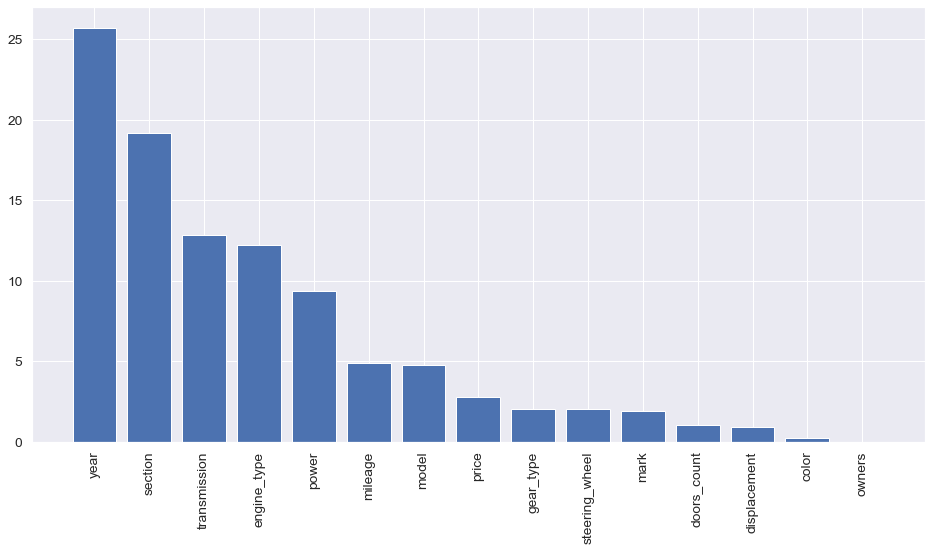

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, features_importances_best_base_model['Importance_(%)'])
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_base_model.index, rotation=90)

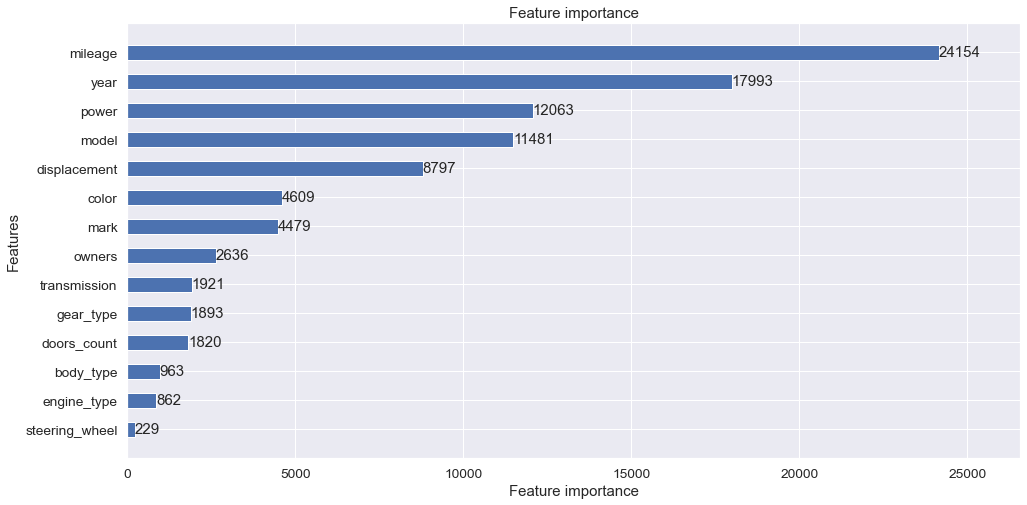

In [107]:
lgbm.plot_importance(best_base_model, height=0.5,  figsize=(16, 8))

The range of prediction for Model No. 0 are: [28851.5, 29179417.6] with the width of 29150566.1
The range of prediction for Model No. 1 are: [28851.6, 29180250.1] with the width of 29151398.4
The range of prediction for Model No. 2 are: [28851.7, 29180286.2] with the width of 29151434.5


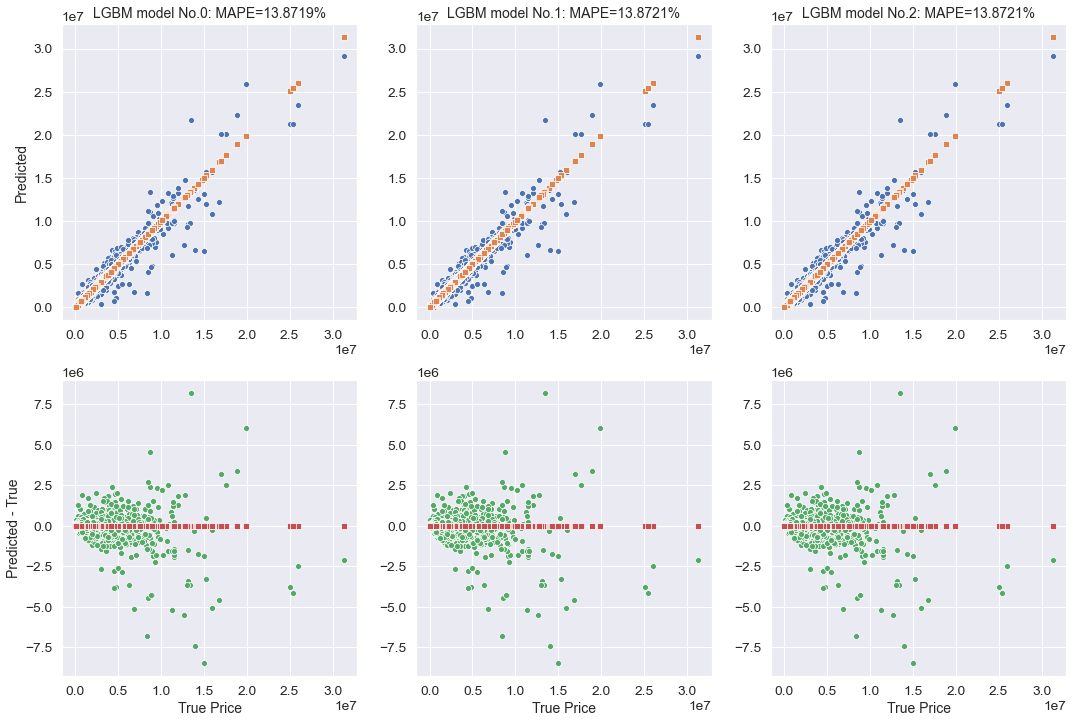

In [108]:
df = base_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_valid1[target_name], prediction)
    sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s')
    plt.title("LGBM model No.{}: MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_valid1[target_name], prediction - data_valid1[target_name], color='g')
    sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

## 6.2 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)

Text(0, 0.5, 'Predicted - True')

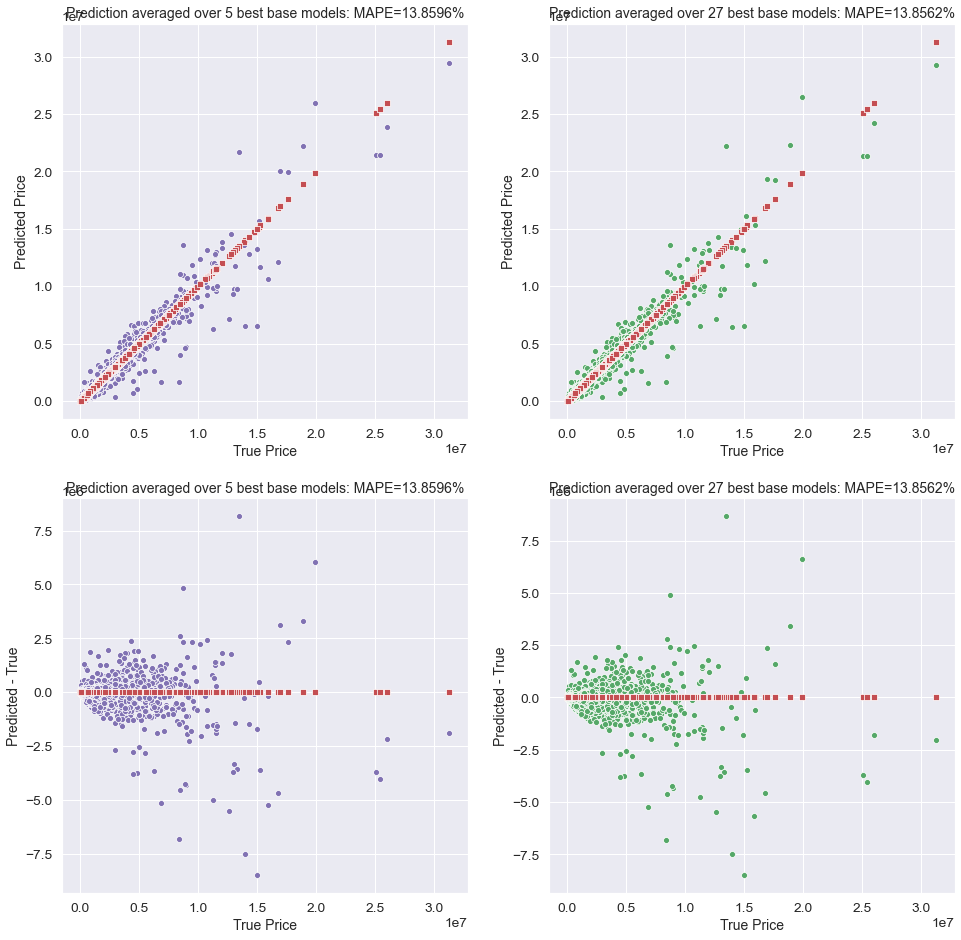

In [109]:
df = base_model_storage

fig, axes = plt.subplots(2, 2, figsize=(16, 16))



### SQRT

n_models = int(np.sqrt(len(df)))

predictions = []

for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_prediction_sqrt = predictions.mean(axis=0)
mape_of_mean_sqrt = mean_absolute_percent_error(data_valid1[target_name], mean_prediction_sqrt)


plt.subplot(2, 2, 1)
sns.scatterplot(data_valid1[target_name], mean_prediction_sqrt, marker='o', color='m')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_valid1[target_name], mean_prediction_sqrt - data_valid1[target_name], marker='o', color='m')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)



### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_prediction_all = predictions.mean(axis=0)
mape_of_mean_all = mean_absolute_percent_error(data_valid1[target_name], mean_prediction_all)


plt.subplot(2, 2, 2)
sns.scatterplot(data_valid1[target_name], mean_prediction_all, marker='o', color='g')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_valid1[target_name], mean_prediction_all - data_valid1[target_name], marker='o', color='g')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [110]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:43:51.655    (H:MM:SS)


<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h1 style="color:red; margin-bottom:20px">
7 STACKING</h1>

</div>

In [111]:
target_train_2 = data_train2[target_name].reset_index(drop=True)
target_valid_2 = data_valid2[target_name].reset_index(drop=True)

In [112]:
%%time

predictions_train_type = []
predictions_valid_type = []
predictions_train = []
predictions_valid = []

features_train_2 = data_train2.drop([target_name], axis=1)
features_valid_2 = data_valid2.drop([target_name], axis=1)


for k, model in enumerate(base_model_storage['model']):
    t0 = time.time()
#     prediction = model.predict(features_train_2)
    prediction_log10 = model.predict(features_train_2)
    prediction = 10**prediction_log10
    predictions_train.append(prediction)
    
#     prediction = model.predict(features_valid_2)
    prediction_log10 = model.predict(features_valid_2)
    prediction = 10**prediction_log10
    predictions_valid.append(prediction)
    print("[{}/{}] : {:.2f} sec".format( k+1, len(base_model_storage), time.time()-t0 ))

data_meta_train = pd.DataFrame(predictions_train).T
data_meta_valid = pd.DataFrame(predictions_valid).T


###  Aceraged prediction

averaged_meta_prediction_train = data_meta_train.mean(axis=1)
data_meta_train['Averaged'] = averaged_meta_prediction_train

averaged_meta_prediction_valid = data_meta_valid.mean(axis=1)
data_meta_valid['Averaged'] = averaged_meta_prediction_valid

data_meta_train[target_name] = target_train_2
data_meta_valid[target_name] = target_valid_2

print(data_meta_train.shape, target_train_2.shape, data_meta_valid.shape, target_valid_2.shape)
running_time(time.time(), total_time_start)

[1/27] : 9.63 sec
[2/27] : 9.37 sec
[3/27] : 9.65 sec
[4/27] : 9.19 sec
[5/27] : 9.76 sec
[6/27] : 9.54 sec
[7/27] : 9.43 sec
[8/27] : 9.71 sec
[9/27] : 9.16 sec
[10/27] : 10.12 sec
[11/27] : 9.49 sec
[12/27] : 9.51 sec
[13/27] : 9.76 sec
[14/27] : 9.32 sec
[15/27] : 9.84 sec
[16/27] : 9.49 sec
[17/27] : 9.44 sec
[18/27] : 9.67 sec
[19/27] : 9.18 sec
[20/27] : 9.57 sec
[21/27] : 9.35 sec
[22/27] : 9.57 sec
[23/27] : 10.28 sec
[24/27] : 9.49 sec
[25/27] : 10.27 sec
[26/27] : 9.75 sec
[27/27] : 9.46 sec
(41061, 29) (41061,) (13687, 29) (13687,)
[***] This is Houston. The MET is : 0:48:14.121    (H:MM:SS)
Wall time: 4min 22s


In [113]:
print("Number of meta-features :", data_meta_valid.shape[1]-1)
data_meta_valid

Number of meta-features : 28


0             1             2             3             4  \
0      2.087747e+06  2.087758e+06  2.087761e+06  2.092789e+06  2.092772e+06   
1      3.049899e+05  3.049916e+05  3.049919e+05  3.094136e+05  3.094111e+05   
2      7.533898e+05  7.533632e+05  7.533641e+05  7.378574e+05  7.378514e+05   
3      4.278797e+05  4.278820e+05  4.278825e+05  4.307972e+05  4.307233e+05   
4      4.990761e+05  4.990788e+05  4.990794e+05  4.940251e+05  4.940211e+05   
...             ...           ...           ...           ...           ...   
13682  2.710404e+06  2.710308e+06  2.710312e+06  2.715529e+06  2.715507e+06   
13683  2.639155e+05  2.639169e+05  2.639172e+05  2.563078e+05  2.563103e+05   
13684  8.920205e+05  8.920253e+05  8.920264e+05  8.888999e+05  8.889088e+05   
13685  1.832529e+06  1.832539e+06  1.832541e+06  1.831734e+06  1.831752e+06   
13686  1.152284e+06  1.152317e+06  1.152318e+06  1.180893e+06  1.180883e+06   

                  5             6             7             8             9  \
0      2.092745e+06  2.095584e+06  2.095582e+06  2.095578e+06  2.089101e+06   
1      3.094072e+05  3.113528e+05  3.113525e+05  3.113520e+05  3.087235e+05   
2      7.378421e+05  7.331304e+05  7.331296e+05  7.331283e+05  7.340045e+05   
3      4.307179e+05  4.309902e+05  4.309988e+05  4.309981e+05  4.156343e+05   
4      4.940177e+05  5.120498e+05  5.120492e+05  5.120483e+05  5.136282e+05   
...             ...           ...           ...           ...           ...   
13682  2.715473e+06  2.724034e+06  2.724031e+06  2.724026e+06  2.707935e+06   
13683  2.563086e+05  2.591876e+05  2.591873e+05  2.591869e+05  2.595166e+05   
13684  8.889027e+05  8.898020e+05  8.898010e+05  8.897994e+05  8.947887e+05   
13685  1.831729e+06  1.841543e+06  1.841541e+06  1.841538e+06  1.840202e+06   
13686  1.180943e+06  1.173036e+06  1.173035e+06  1.173033e+06  1.113087e+06   

       ...            19            20            21            22  \
0      ...  2.089047e+06  2.089341e+06  2.079964e+06  2.079948e+06   
1      ...  3.092042e+05  3.091098e+05  3.060456e+05  3.060432e+05   
2      ...  7.417037e+05  7.417002e+05  7.087835e+05  7.087781e+05   
3      ...  4.184722e+05  4.179144e+05  4.242341e+05  4.238349e+05   
4      ...  5.000010e+05  5.000020e+05  5.126970e+05  5.126931e+05   
...    ...           ...           ...           ...           ...   
13682  ...  2.736106e+06  2.736093e+06  2.736054e+06  2.736034e+06   
13683  ...  2.605377e+05  2.605382e+05  2.577531e+05  2.577550e+05   
13684  ...  8.914928e+05  8.914945e+05  8.916934e+05  8.916999e+05   
13685  ...  1.835767e+06  1.835771e+06  1.838998e+06  1.838984e+06   
13686  ...  1.146076e+06  1.146070e+06  1.148966e+06  1.148957e+06   

                 23            24            25            26      Averaged  \
0      2.080157e+06  2.094053e+06  2.094080e+06  2.094104e+06  2.088534e+06   
1      3.056925e+05  3.136924e+05  3.136963e+05  3.137000e+05  3.098882e+05   
2      7.087859e+05  7.165431e+05  7.165322e+05  7.165293e+05  7.345660e+05   
3      4.242355e+05  4.262720e+05  4.262655e+05  4.262638e+05  4.268089e+05   
4      5.126987e+05  4.931230e+05  4.929811e+05  4.928419e+05  5.017457e+05   
...             ...           ...           ...           ...           ...   
13682  2.736064e+06  2.715645e+06  2.715603e+06  2.715635e+06  2.717652e+06   
13683  2.577539e+05  2.619827e+05  2.619860e+05  2.619891e+05  2.595607e+05   
13684  8.916964e+05  8.995112e+05  8.995224e+05  8.995330e+05  8.940964e+05   
13685  1.839004e+06  1.840230e+06  1.840202e+06  1.840195e+06  1.837664e+06   
13686  1.148994e+06  1.153903e+06  1.153917e+06  1.153931e+06  1.159042e+06   

         price  
0      1939000  
1       235000  
2       660000  
3       475000  
4       515000  
...        ...  
13682  2299000  
13683   245000  
13684   962000  
13685  1847200  
13686  1473000  

[13687 rows x 29 columns]

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h2 style="color:red; margin-bottom:20px">
7.1 BLENDING</h2>

</div>

### 7.1.1 Prediction averaging (Bagging)

In [114]:
mape_averaged_meta_valid = mean_absolute_percent_error(data_meta_valid[target_name], data_meta_valid['Averaged'])
print("We have MAPE={:.4f} for the prediction which is averaged over all meta-predictions".format(mape_averaged_meta_valid))

We have MAPE=13.6334 for the prediction which is averaged over all meta-predictions


Text(0, 0.5, 'Predicted - True')

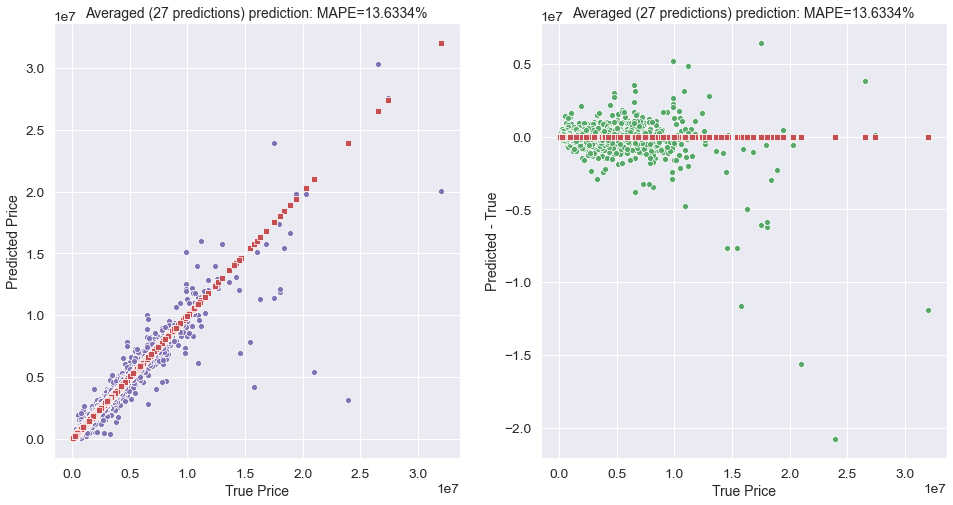

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged'], marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(1, 2, 2)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged']-data_meta_valid[target_name], marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

### 7.1.2 Prediction weight averaging (LinerRegression)

In [116]:
%%time

model = LinearRegression()
model.fit(data_meta_train.drop([target_name], axis=1), data_meta_train[target_name])
prediction_blend = model.predict(data_meta_valid.drop([target_name], axis=1))
mape_blend = mean_absolute_percent_error(data_meta_valid[target_name], prediction_blend)

print("With the simplest blending procedure we got MAPE = {:.4f}".format(mape_blend))

running_time(time.time(), total_time_start)

With the simplest blending procedure we got MAPE = 14.6774
[***] This is Houston. The MET is : 0:48:15.245    (H:MM:SS)
Wall time: 96 ms


In [117]:
print("Let us compare the intercept coeff of LinearRegression ({:.2f}) with the mean taget value ({:.2f}) :  intercept/mean = {:.2%}"
      .format( model.intercept_, data_meta_valid[target_name].mean(), model.intercept_/data_meta_valid[target_name].mean() ))

Let us compare the intercept coeff of LinearRegression (8405.59) with the mean taget value (1042842.90) :  intercept/mean = 0.81%


Text(0, 0.5, 'Predicted - True')

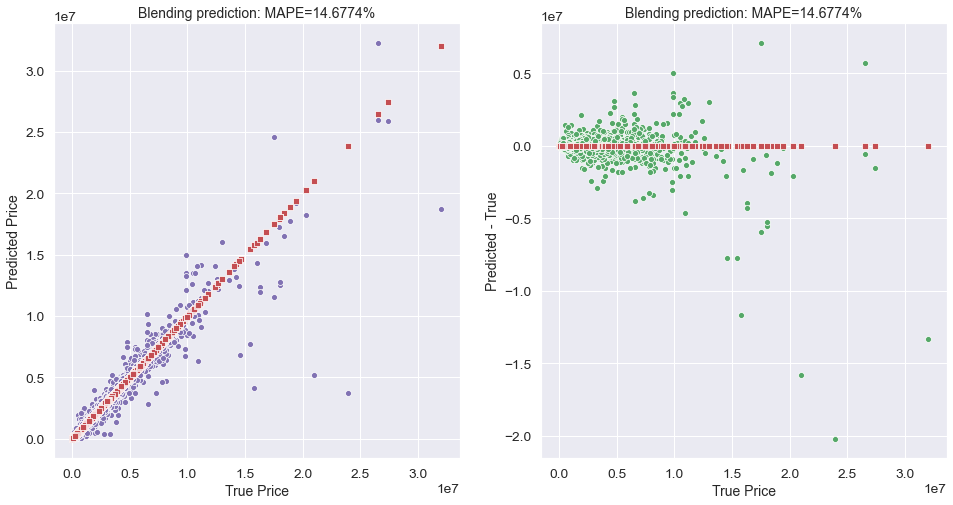

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))


plt.subplot(1, 2, 1)
sns.scatterplot(data_meta_valid[target_name], prediction_blend, marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Blending prediction: MAPE={:.4f}%".format(mape_blend), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(1, 2, 2)
sns.scatterplot(data_meta_valid[target_name], prediction_blend-data_meta_valid[target_name], marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

plt.title("Blending prediction: MAPE={:.4f}%".format(mape_blend), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [119]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:48:16.98    (H:MM:SS)


<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h2 style="color:red; margin-bottom:20px">
7.3 Stacking  with LightGBM</h2>

</div>

In [120]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}
param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### variable parameters

params_lim = {}

# params_lim['n_estimators'] = [160, 480, 'int']
# params_lim['max_depth'] = [2, 22, 'int']
# params_lim['learning_rate'] = [0.0001, 0.2001, 'float']

params_lim['n_estimators'] = [2, 3000, 'int']
params_lim['max_depth'] = [2, 102, 'int']
params_lim['learning_rate'] = [0.0001, 2.0001, 'float']

[0]
params_limits : {'n_estimators': [2, 3000, 'int'], 'max_depth': [2, 102, 'int'], 'learning_rate': [0.0001, 2.0001, 'float']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 13.769863 (tol=0.0001)
result_dict {'n_estimators': 151, 'max_depth': 7, 'learning_rate': 0.10010000000000001}
Iteration time = 179.21 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [2, 301, 'int'], 'max_depth': [2, 12, 'int'], 'learning_rate': [0.00010000000000000286, 0.2001, 'float']}
OUT [1]: M(i) = 13.769863; M(i+1) = 13.730303 (tol=0.0001)
result_dict {'n_estimators': 61, 'max_depth': 4, 'learning_rate': 0.1101}
Iteration time = 29.10 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[2]
params_limits : {'n_estimators': [46, 76, 'int'], 'max_depth': [3, 5, 'int'], 'learning_rate': [0.10010000000000001, 0.1201, 'float']}
OUT [2]: M(i) = 13.730303; M(i+1) = 13.726637 (tol=0.0001)
result_dict {'n_estimators': 59, 'max_depth': 4, 'learning_rate': 0.10210000000000001}
Iteration time = 16.56 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[3]
params_limits : {'n_estimators': [57, 61, 'int'], 'max_depth': [3, 5, 'int'], 'learning_rate': [0.10110000000000001, 0.1031000000

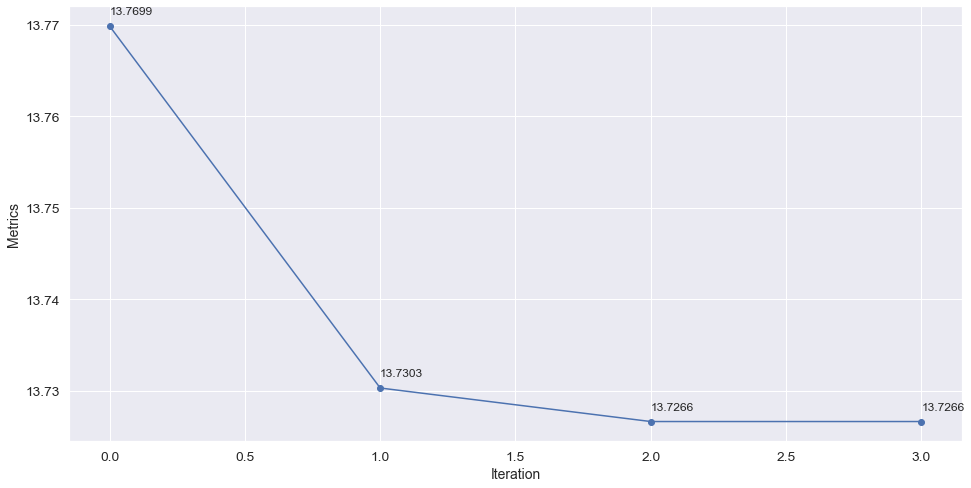


Done. Congratulations!
[***] This is Houston. The MET is : 0:52:10.955    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best meta model are:  {'n_estimators': 59, 'max_depth': 4, 'learning_rate': 0.10210000000000001}
The best meta model has MAPE=13.7266
Wall time: 3min 54s


In [121]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_meta_train, data_meta_valid, target_name, N_SAMPLE_META, 
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best meta model are: ", result_dict)
print("The best meta model has MAPE={:.4f}".format(metrics_out))

In [122]:
best_meta_model_mape = metrics_out
best_parameters_meta = result_dict
print("The best parameters for the meta model are: ", best_parameters_meta)
print("We have the MAPE = {:.4f} for the best meta model. ".format(best_meta_model_mape))

The best parameters for the meta model are:  {'n_estimators': 59, 'max_depth': 4, 'learning_rate': 0.10210000000000001}
We have the MAPE = 13.7266 for the best meta model. 


### 7.3.2 Collect an ensemle of nearly best meta models

In [123]:
EstimatorClass = 'lgbm'



### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}
param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters
n_es_0 = best_parameters['n_estimators']
md_0 = best_parameters['max_depth']
lr_0 = np.round(best_parameters['learning_rate'], 9)

params_optim = {}
params_optim['n_estimators'] =  [ max([2, n_es_0-STEP_INT]), n_es_0, n_es_0+STEP_INT ]
params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]
params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]

# params_optim = {}
# params_optim['n_estimators'] = [419, 420, 421] ## 420
# params_optim['max_depth'] = [20, 21, 22] ## 21
# params_optim['learning_rate'] = [0.115, 0.116, 0.117] ## 0.1161336

params_optim

{'n_estimators': [3130, 3131, 3132],
 'max_depth': [15, 16, 17],
 'learning_rate': [0.0198, 0.0208, 0.0218]}

In [124]:
%%time
meta_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                                      data_meta_train, data_meta_valid, target_name, N_SAMPLE_META, 
                                      metrics_func=mean_absolute_percent_error,
                                      lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto')

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'learning_rate', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3130, 15, 0.0198, 13.995728376392288, 13.830650329589844, <lightgbm.basic.Booster object at 0x0000014354A09748>]
[3130, 15, 0.0208, 14.000108917444168, 13.9891197681427, <lightgbm.basic.Booster object at 0x0000014354177848>]
[3130, 15, 0.0218, 14.007243481271638, 13.686645984649658, <lightgbm.basic.Booster object at 0x000001435270CDC8>]
[3130, 16, 0.0198, 13.986987752432858, 13.934181928634644, <lightgbm.basic.Booster object at 0x00000143527C1EC8>]
[3130, 16, 0.0208, 13.998576828445387, 13.75865650177002, <lightgbm.basic.Booster object at 0x0000014354201108>]
[3130, 16, 0.0218, 14.008072070762406, 14.072644233703613, <lightgbm.basic.Booster object at 0x00000143541EA148>]
[3130, 17, 0.0198, 13.997407687229257, 14.201282739639282, <lightgbm.basic.Booster object at 0x00000143541E04C8>]
[3130, 17, 0.0208, 13.999027420202308, 14.455713748931885, <lightgbm.basic.Booster object at 0x00000143540ECFC8>]
[3130, 17, 0.0218, 14.012474496183211, 14.423849821090698, <lightgbm.basic.Booster object a

In [125]:
meta_model_storage

n_estimators max_depth  learning_rate    metrics  performance_time  \
0          3131        16         0.0198  13.986953         13.778674   
1          3130        16         0.0198  13.986988         13.934182   
2          3132        16         0.0198  13.987043         13.618716   
3          3130        15         0.0198  13.995728         13.830650   
4          3131        15         0.0198  13.995825         14.079633   
5          3132        15         0.0198  13.995840         14.660101   
6          3132        17         0.0198  13.997311         14.396096   
7          3131        17         0.0198  13.997326         14.311180   
8          3130        17         0.0198  13.997408         14.201283   
9          3130        16         0.0208  13.998577         13.758657   
10         3132        16         0.0208  13.998642         14.180065   
11         3131        16         0.0208  13.998699         13.891181   
12         3131        17         0.0208  13.998984         14.279622   
13         3130        17         0.0208  13.999027         14.455714   
14         3132        17         0.0208  13.999029         14.310637   
15         3130        15         0.0208  14.000109         13.989120   
16         3132        15         0.0208  14.000157         13.814105   
17         3131        15         0.0208  14.000157         13.788162   
18         3131        15         0.0218  14.007236         13.731097   
19         3130        15         0.0218  14.007243         13.686646   
20         3132        15         0.0218  14.007259         13.588121   
21         3130        16         0.0218  14.008072         14.072644   
22         3131        16         0.0218  14.008173         13.836707   
23         3132        16         0.0218  14.008284         14.150260   
24         3131        17         0.0218  14.012458         14.394759   
25         3130        17         0.0218  14.012474         14.423850   
26         3132        17         0.0218  14.012580         14.307232   

                                                model  
0   <lightgbm.basic.Booster object at 0x0000014354...  
1   <lightgbm.basic.Booster object at 0x0000014352...  
2   <lightgbm.basic.Booster object at 0x0000014352...  
3   <lightgbm.basic.Booster object at 0x0000014354...  
4   <lightgbm.basic.Booster object at 0x0000014354...  
5   <lightgbm.basic.Booster object at 0x0000014351...  
6   <lightgbm.basic.Booster object at 0x0000014352...  
7   <lightgbm.basic.Booster object at 0x0000014354...  
8   <lightgbm.basic.Booster object at 0x0000014354...  
9   <lightgbm.basic.Booster object at 0x0000014354...  
10  <lightgbm.basic.Booster object at 0x0000014352...  
11  <lightgbm.basic.Booster object at 0x0000014354...  
12  <lightgbm.basic.Booster object at 0x000001434D...  
13  <lightgbm.basic.Booster object at 0x0000014354...  
14  <lightgbm.basic.Booster object at 0x0000014352...  
15  <lightgbm.basic.Booster object at 0x0000014354...  
16  <lightgbm.basic.Booster object at 0x0000014354...  
17  <lightgbm.basic.Booster object at 0x0000014354...  
18  <lightgbm.basic.Booster object at 0x0000014354...  
19  <lightgbm.basic.Booster object at 0x0000014352...  
20  <lightgbm.basic.Booster object at 0x0000014354...  
21  <lightgbm.basic.Booster object at 0x0000014354...  
22  <lightgbm.basic.Booster object at 0x0000014354...  
23  <lightgbm.basic.Booster object at 0x0000014352...  
24  <lightgbm.basic.Booster object at 0x0000014354...  
25  <lightgbm.basic.Booster object at 0x0000014355...  
26  <lightgbm.basic.Booster object at 0x0000014352...

### About the best meta model

In [126]:
best_meta_model = meta_model_storage.loc[0, "model"]
print("Best base model demonstrates MAPE = {:.4f} with 'valid1' sample."
      .format(meta_model_storage.loc[0, "metrics"]))

Best base model demonstrates MAPE = 13.9870 with 'valid1' sample.


In [127]:
features_importances_best_meta_model = pd.DataFrame(
    data=100*best_meta_model.feature_importance()/best_meta_model.feature_importance().sum(), 
    index=data_meta_train.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

features_importances_best_meta_model = features_importances_best_meta_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False).head(20)

features_importances_best_meta_model

Importance_(%)
18             10.474913
15              9.936146
0               8.851961
21              8.233377
9               8.111434
24              7.920759
3               7.824313
6               7.817662
12              7.084895
Averaged        4.823404
23              3.155001
13              2.915549
26              1.666186
4               1.093054
5               1.064231
11              1.056471
1               1.037625
20              1.019888
2               0.881316
7               0.855819

[6.23843601] [0.04223244]
We have not 4.2% of features


([<matplotlib.axis.XTick at 0x1435438e4c8>,
 [Text(0, 0, '18'),
  Text(0, 0, '15'),
  Text(0, 0, '0'),
  Text(0, 0, '21'),
  Text(0, 0, '9'),
  Text(0, 0, '24'),
  Text(0, 0, '3'),
  Text(0, 0, '6'),
  Text(0, 0, '12'),
  Text(0, 0, 'Averaged'),
  Text(0, 0, '23'),
  Text(0, 0, '13'),
  Text(0, 0, '26'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '11'),
  Text(0, 0, '1'),
  Text(0, 0, '20'),
  Text(0, 0, '2'),
  Text(0, 0, '7')])

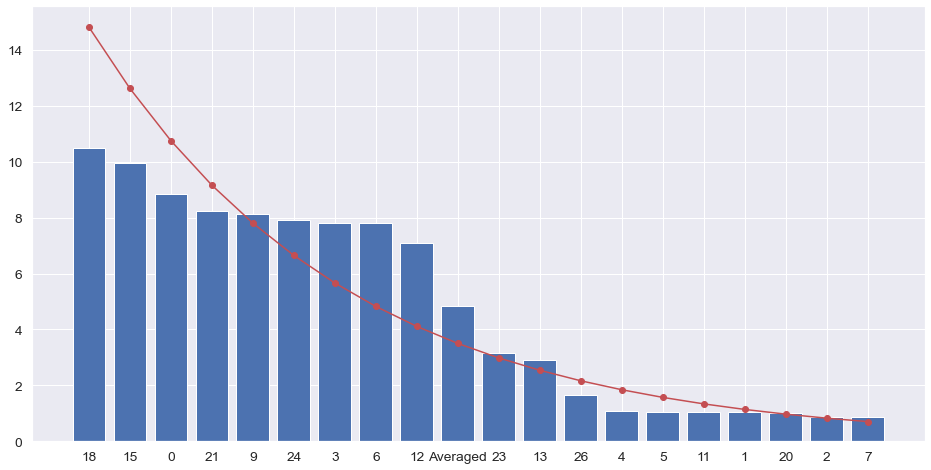

In [128]:
y = np.log(features_importances_best_meta_model.values)
x = np.arange(1, len(y)+1)

p = np.polyfit(x, y, 1)
length = -1/p[0]
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )
print(length, feature_deficiency)
print("We have not {:.1%} of features".format(float(feature_deficiency)))

real_importance = np.exp( np.polyval(p, x) )



fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, features_importances_best_meta_model['Importance_(%)'])
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_meta_model.index)

The range of prediction for Model No. 0 are: [30269.9, 13048997.0] with the width of 13018727.1
The range of prediction for Model No. 1 are: [30269.9, 13049179.3] with the width of 13018909.4
The range of prediction for Model No. 2 are: [30269.9, 13048672.3] with the width of 13018402.4


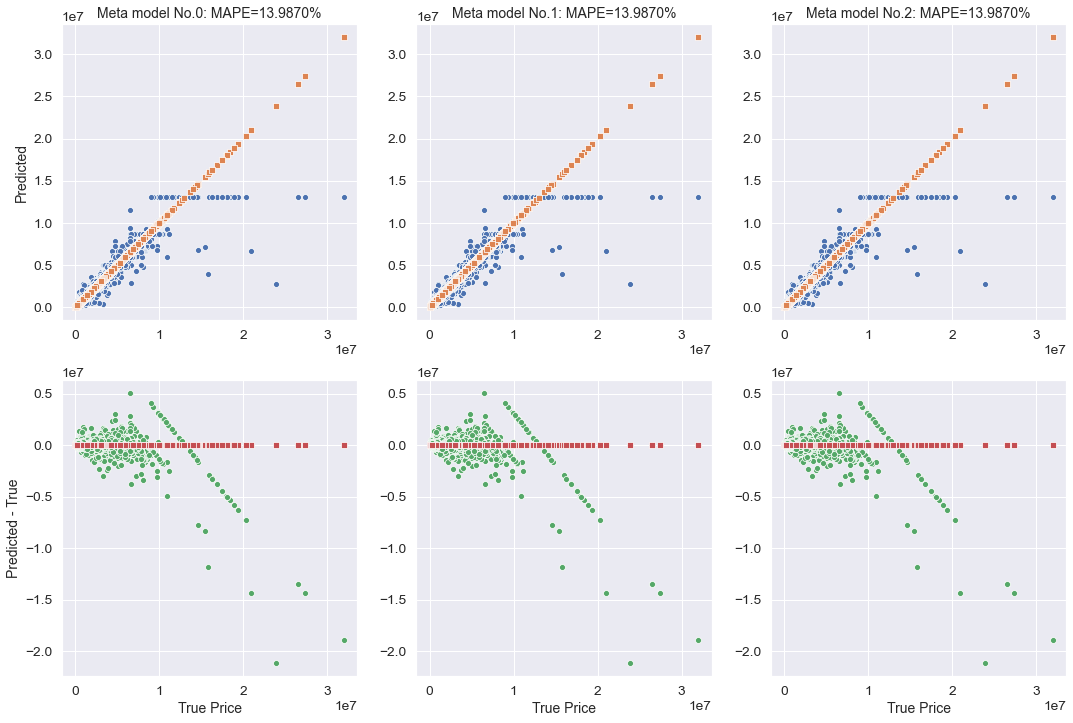

In [129]:
df = meta_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_meta_valid[target_name], prediction)
    sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s')
    plt.title("Meta model No.{}: MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_meta_valid[target_name], prediction - data_meta_valid[target_name], color='g')
    sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                    marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

###  7.3.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)

Text(0, 0.5, 'Predicted - True')

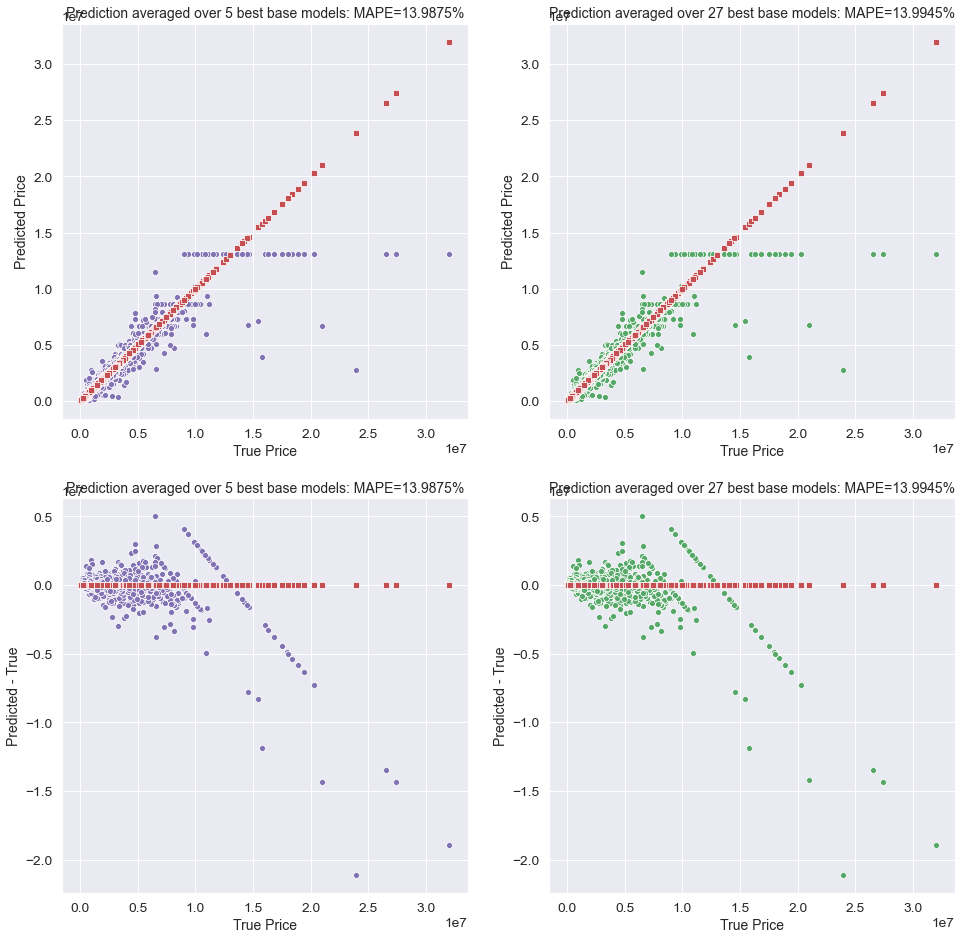

In [130]:
df = meta_model_storage

fig, axes = plt.subplots(2, 2, figsize=(16, 16))



### SQRT

n_models = int(np.sqrt(len(df)))

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
meta_mean_prediction_sqrt = predictions.mean(axis=0)
meta_mape_of_mean_sqrt = mean_absolute_percent_error(data_meta_valid[target_name], meta_mean_prediction_sqrt)


plt.subplot(2, 2, 1)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_sqrt, marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_sqrt - data_meta_valid[target_name], 
                marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)



### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
meta_mean_prediction_all = predictions.mean(axis=0)
meta_mape_of_mean_all = mean_absolute_percent_error(data_meta_valid[target_name], meta_mean_prediction_all)


plt.subplot(2, 2, 2)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_all, marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_all - data_meta_valid[target_name], 
                marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [131]:
performance_time = time.time() - total_time_start

running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:59:54.652    (H:MM:SS)


In [132]:
def two_digit_presentation(x):
    if x < 10:
        return "0" + str(x)
    else:
        return str(x)
    

    
def two_digit_time_presentation(x):
    hours = x//3600
    minutes = ( x - 3600*hours) // 60
    seconds = x - 3600*hours - 60*minutes
    if hours > 0:
        ans = (two_digit_presentation(int(hours)) +  " h " 
               + two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    elif minutes > 0:
        ans = (two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    else:
        ans = (two_digit_presentation(round(seconds, 3)) + " sec")
    return ans

<div class="alert alert-block alert-info">
<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">
99 Results</h1>

</div>

In [133]:
print("We have MAPE={:.4f} for unoptimized model.".format(mape_unoptimized))


final_results = pd.DataFrame({'Action': ["Unoptimized model",
                                         "Best base model", "Base base averaged (sqrt 1)", 
                                         "Base base averaged (all 1)", "Base base averaged (all 2)", 
                                         "Blending with LinearRegression", "Best meta model", 
                                         "Meta averaged (sqrt 2)", "Meta averaged (all 2)]"],
                              "MAPE": [mape_unoptimized,
                                       base_model_storage.loc[0, "metrics"],  mape_of_mean_sqrt, 
                                       mape_of_mean_all, mape_averaged_meta_valid, 
                                       mape_blend, meta_model_storage.loc[0, "metrics"], 
                                       meta_mape_of_mean_sqrt, meta_mape_of_mean_all],
                              "Description": ["LightGBM with default parameters",
                                              "Calculated with valid_1.", 
                                              "Averaged over {} best models [valid_1]."
                                              .format( int(np.sqrt( len(base_model_storage) )) ), 
                                              ##
                                              "Averaged over {} best models [valid_1]."
                                              .format( len(base_model_storage) ), 
                                              "Averaged over {} best models [valid_2]."
                                              .format( len(base_model_storage) ), 
                                              ##
                                              "Weighted mean for {} predictions (with averaged) [valid_2]."
                                              .format( data_meta_valid.shape[1]-1 ), 
                                              "Calculated with valid_2.",
                                              ##
                                              "Averaged over {} best meta models [valid_2]."
                                              .format( int(np.sqrt( len(base_model_storage) )) ), 
                                              "Averaged over {} best meta models [valid_2]."
                                              .format( len(base_model_storage) ) ],
                              "Phase" : ["", "", "BAGGING", 
                                         "BAGGING", "BLENDING", 
                                         "STACKING", "BLENDING", 
                                         "STACKING", "STACKING"]})
final_results

We have MAPE=14.5330 for unoptimized model.


Action       MAPE  \
0               Unoptimized model  14.533008   
1                 Best base model  13.871864   
2     Base base averaged (sqrt 1)  13.859580   
3      Base base averaged (all 1)  13.856205   
4      Base base averaged (all 2)  13.633435   
5  Blending with LinearRegression  14.677422   
6                 Best meta model  13.986953   
7          Meta averaged (sqrt 2)  13.987498   
8          Meta averaged (all 2)]  13.994487   

                                         Description     Phase  
0                   LightGBM with default parameters            
1                           Calculated with valid_1.            
2             Averaged over 5 best models [valid_1].   BAGGING  
3            Averaged over 27 best models [valid_1].   BAGGING  
4            Averaged over 27 best models [valid_2].  BLENDING  
5  Weighted mean for 28 predictions (with average...  STACKING  
6                           Calculated with valid_2.  BLENDING  
7        Averaged over 5 best meta models [valid_2].  STACKING  
8       Averaged over 27 best meta models [valid_2].  STACKING

In [134]:
final_results.sort_values('MAPE', ascending=True)

Action       MAPE  \
4      Base base averaged (all 2)  13.633435   
3      Base base averaged (all 1)  13.856205   
2     Base base averaged (sqrt 1)  13.859580   
1                 Best base model  13.871864   
6                 Best meta model  13.986953   
7          Meta averaged (sqrt 2)  13.987498   
8          Meta averaged (all 2)]  13.994487   
0               Unoptimized model  14.533008   
5  Blending with LinearRegression  14.677422   

                                         Description     Phase  
4            Averaged over 27 best models [valid_2].  BLENDING  
3            Averaged over 27 best models [valid_1].   BAGGING  
2             Averaged over 5 best models [valid_1].   BAGGING  
1                           Calculated with valid_1.            
6                           Calculated with valid_2.  BLENDING  
7        Averaged over 5 best meta models [valid_2].  STACKING  
8       Averaged over 27 best meta models [valid_2].  STACKING  
0                   LightGBM with default parameters            
5  Weighted mean for 28 predictions (with average...  STACKING

In [135]:
time_string_launch = date_start.strftime("%d %B %Y") + " at " + time_start.strftime("%H:%M")

date_finish = datetime.date.today()
time_finish = datetime.datetime.now().time()
time_string_finish = date_finish.strftime("%d %B %Y") + " at " + time_finish.strftime("%H:%M")


print( "The code was launched on              ", time_string_launch )
print( "The code finished its performance on  ", time_string_finish )
print()
print( "The full performance time is " + two_digit_time_presentation( performance_time ) )

The code was launched on               23 July 2020 at 23:28
The code finished its performance on   24 July 2020 at 00:28

The full performance time is 59 min 54 sec
